## ** The Improved Power Disaggregation (Non-intrusive Load Monitoring) **

- Author : Gyubaek Kim (database.kim@yonsei.ac.kr)
- Description
  * Building a common pre-trained model for rice cooker is descrbied. And, chaining that refers to additional training with untarget appliances is applied to improved performance. Finally, a result processing scheme is introduced.
- License
   * All rights reserved. No part of this code may be reproduced or transmitted in any form or by any means, or utilized by any information storage and retrieval system without written permission from the copyright owner. You can use this source code for free projects only. I will not allow commercial use of this code. I am not allowing anyone to modify any or all parts of the source code for commercial purposes. By using my source code, you agree to the following: 
       * 1. You will not distribute any or all parts of this source code for commercial use 
       * 2. You will cite me as the original creator of this source code. 
       * 3. You will inform me of its use before you use any or all parts of this source code. 
   For use of any or all parts of this source code, email me. This source code is provided free to use for everybody provided this is used non-commercially. Violators of this agreement will be subject to legal action by the author. If you see commercial applications or software using any or all parts of this source code, inform me.  

In [352]:
#### NIMLTK as common framework ####
from nilmtk.utils import find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.legacy.disaggregate import Disaggregator
from nilmtk.datastore import HDFDataStore
from nilmtk import DataSet

#### Benchmark Resource ####
from benchmark.rnndisaggregator import RNNDisaggregator
from benchmark.grudisaggregator import GRUDisaggregator
from benchmark.windowgrudisaggregator import WindowGRUDisaggregator
from benchmark.daedisaggregator import DAEDisaggregator
from benchmark.shortseq2pointdisaggregator import ShortSeq2PointDisaggregator
from benchmark.metrics import recall_precision_accuracy_f1, recall_precision_accuracy_f1_2, relative_error_total_energy, mean_absolute_error

from work.benchmark.rnndisaggregator_fe import RNNDisaggregatorFE
from work.benchmark.grudisaggregator_fe import GRUDisaggregatorFE
from work.benchmark.windowgrudisaggregator_fe import WindowGRUDisaggregatorFE
from work.benchmark.daedisaggregator_fe import DAEDisaggregatorFE
from work.benchmark.shortseq2pointdisaggregator_fe import ShortSeq2PointDisaggregatorFE

#### Our Model ####
from work.dtdisaggregator import DTDisaggregator
from work.utils import checkSimilarity

import pandas as pd
import numpy as np
import h5py
import numpy.random
import time
import datetime
import math
import itertools
import warnings

from scipy.signal import find_peaks, find_peaks_cwt
from sklearn.metrics import precision_score

from matplotlib import rcParams
import matplotlib.pyplot as plt

numpy.random.seed(42)
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['figure.figsize'] = (23, 10)
plt.rcParams['axes.grid'] = True 

#### Configuration

In [353]:
###############################################################
# Common
###############################################################
TRAIN_SAMPLE_PERIOD = 6
TEST_SAMPLE_PERIOD = 6

EPOCHS = 1

DATA_FILE = '../enertalk/enertalk-converted/enertalk.h5'

appliances = ['television', 'washing machine', 'rice cooker', 'water filter', 'microwave']

In [366]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
def compute_result(gt, pred):
    
    print('recall = ' + str(recall_score(gt, pred)))
    print('precision = ' + str(precision_score(gt, pred)))
    print('accuracy = ' + str(accuracy_score(gt, pred)))
    print('f1 = ' + str(f1_score(gt, pred)))

### Result Processing
* This process is executed after disaggregation is done.

In [632]:
plt.rcParams['axes.grid'] = True 
def count_num_of_activations(total, predicted, ground_truth, appliance_max):
   
    if ground_truth is not None:
        gt = ground_truth.power_series_all_data(sample_period=TEST_SAMPLE_PERIOD)   
 
    if predicted is not None:
        pred = predicted.power_series_all_data(sample_period=TEST_SAMPLE_PERIOD)

    ix = gt.index.intersection(pred.index)           
    gt = gt[ix]
    pred = pred[ix]

    legends = []    
    
#    t = total.power_series_all_data()    
#    plt.plot(t, linewidth=2)
#    legends.append('total')

#    plt.plot(gt, linewidth=2)
#    legends.append('appliance (actual)')    

    gt = gt.rolling(window=600, center=True, min_periods=1).mean()
#    plt.plot(gt, linewidth=2)
#    legends.append('appliance (actual & rolled)')
    
    plt.plot(pred, linewidth=2)
    legends.append('appliance (predicted)')   

    ##############################################################
    # 1. Denoising
    ##############################################################

    least_amount = appliance_max / 10
    print('least_amount = ' + str(least_amount))  

        
    pred[pred < least_amount] = 0       
    
    plt.plot(pred, linewidth=2)
    legends.append('appliance (denoising)')   
    
#    plt.axhline(y=least_amount, color='r', linestyle='--', linewidth=2)
   
    ##############################################################
    # 2. Smoothing
    ##############################################################
    pred = pred.rolling(window=600, center=True, min_periods=1).mean()
    plt.plot(pred, linewidth=2)
    legends.append('appliance (predicted & rolled)')        

    ##############################################################
    # 3. Thresholding
    ##############################################################
    
    upper = pred.max() * 0.5
    print('upper = ' + str(upper))

    plt.axhline(y=upper, color='r', linestyle='--', linewidth=2)
#    legends.append('appliance (quantile)')     

    ##############################################################
    # 4. Investigating
    ##############################################################

    peaks = []
    
    pred_len = len(pred)    
    pred_unit = 600 # 1 hour
    
    final_gt = []
    final_pred = []    
    
    for i in range(int(pred_len/pred_unit)):
        consumption1 = 0
        consumption2 = 0
        count1 = 0
        count2 = 0
        
        for j in range(pred_unit): 
            idx = i * pred_unit + j
           
            if idx >= pred_len:
                break
            
            if pred[idx] > upper and pred[idx] > 10:
                count1 = count1 + 1
            if gt[idx] > 0:
                count2 = count2 + 1
            
            consumption1 = consumption1 + pred[idx]
            consumption2 = consumption2 + gt[idx]
       
        if count1 > int(600*0.25):
            
            peaks.append(i*600+300)
            
            print(pred.index[i*600])
            print('count1 = ' + str(count1))
            print('count2 = ' + str(count2))            
            
            if count2 > int(600*0.25):
                final_gt.append(1)
                final_pred.append(1)
            else:
                final_gt.append(0)
                final_pred.append(1)                
        else:
            if count2 > int(600*0.25):
                final_gt.append(1)
                final_pred.append(0)                
            else:
                final_gt.append(0)
                final_pred.append(0)  
                
    ##############################################################
    # * Performance Evaluation
    ##############################################################                
            
    compute_result(final_gt, final_pred)
    
    print('# of peaks = ' + str(len(peaks)))    
    print(f'activations : {peaks}')
    
    pred[peaks] = upper
    
    plt.plot(pred.index[peaks], pred[peaks], "bo")
    plt.legend(legends)    
    plt.ylim([0, 530])
    plt.show()    
    
    return len(peaks)

In [633]:
# start_time, end_time : YYYY-MM-DD HH:MI:SS
def disaggregate(dataset, model, home_id, appliance, start_time, end_time, evaluate=False):
    
    dataset.set_window(start=start_time, end=end_time)
    
    test_elec = dataset.buildings[home_id].elec    
    test_mains = test_elec.all_meters()[0]   
    test_meter = test_elec.submeters()[appliance]
    
    tempfile = 'work/temp/' + str(time.time())
    
    output = HDFDataStore(tempfile, 'w')    
    model.disaggregate(test_mains, output, test_meter, sample_period=TEST_SAMPLE_PERIOD)
    output.close()
    
    result = DataSet(tempfile)    
    res_elec = result.buildings[home_id].elec

    predicted = res_elec[appliance] 
    
    ground_truth = None
   
    if evaluate == True:
        
        ground_truth = test_elec[appliance]

        # Performance Metric
        print("============ Relative error in total energy: {}".format(relative_error_total_energy(predicted, ground_truth)))
        print("============ Mean absolute error(in Watts): {}".format(mean_absolute_error(predicted, ground_truth)))
        
        # Performance Metric
        rpaf = recall_precision_accuracy_f1(predicted, ground_truth)
        #rpaf = recall_precision_accuracy_f1_2(predicted, ground_truth, int(model.meter_mmax / 10))
        #rpaf = recall_precision_accuracy_f1_2(predicted, ground_truth, 100)
        print("============ Recall: {}".format(rpaf[0]))
        print("============ Precision: {}".format(rpaf[1]))
        print("============ Accuracy: {}".format(rpaf[2]))
        print("============ F1 Score: {}".format(rpaf[3]))
        
    return count_num_of_activations(test_mains, predicted, ground_truth, model.meter_mmax)

### Pre-training

In [357]:
# enertalk.set_window(start='2017-01-01 00:00:00', end='2017-01-15 00:00:00')
# 1, 2, 9, 10, 13, 14, 18, 22

# enertalk.set_window(start='2016-10-01 00:00:00', end='2016-10-15 00:00:00')
# 3, 5, 6

# enertalk.set_window(start='2017-04-01 00:00:00', end='2017-04-15 00:00:00')
# 12, 21

# no rice cooker
# 4, 7, 8, 11, 15, 16, 17, 19, 20

#i_list = [1, 2, 3, 5, 6, 9, 10, 12, 13, 14, 18, 21, 22]

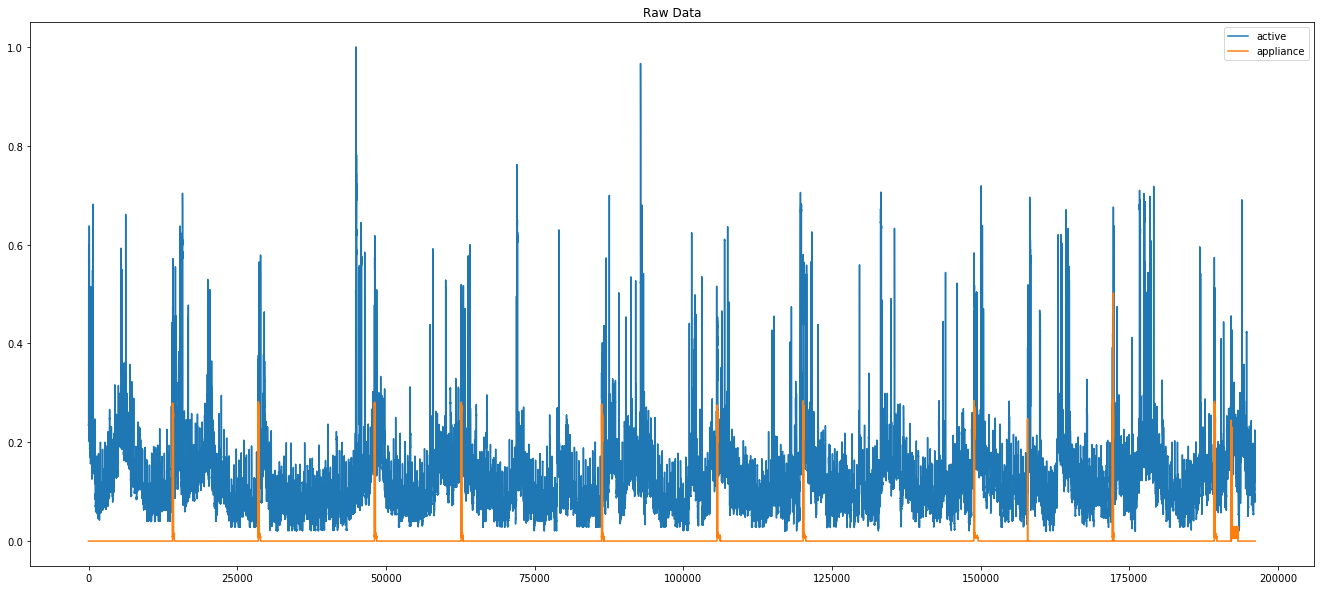

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.2min finished


model fit is done..
a9      0.372190
max     0.127335
diff    0.090025
min     0.076120
std     0.061715
a1      0.045563
a0      0.031437
a8      0.024528
q0      0.023705
q2      0.020272
q1      0.020268
f5      0.011186
a7      0.008514
f1      0.007614
f9      0.007020
a2      0.006591
a5      0.006558
f6      0.006466
a6      0.006368
f4      0.006264
f3      0.005776
a3      0.005398
f7      0.005159
f2      0.005148
f8      0.005078
a4      0.005065
f0      0.004367
mean    0.004270
dtype: float64


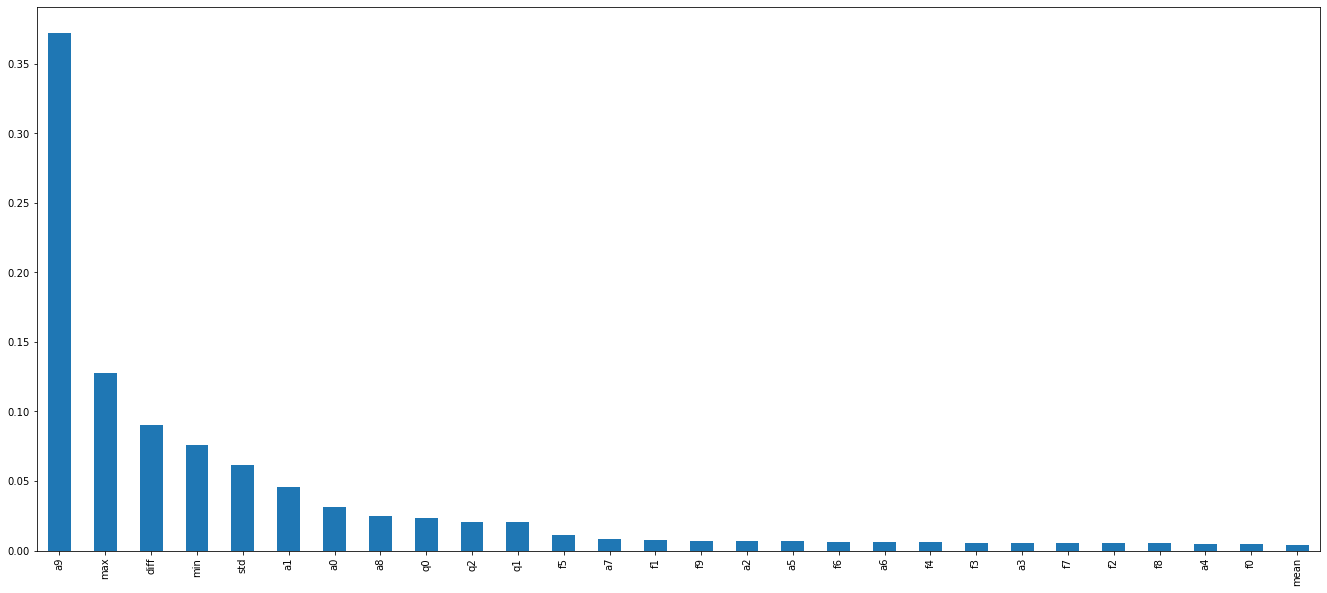

train on chunk is done..


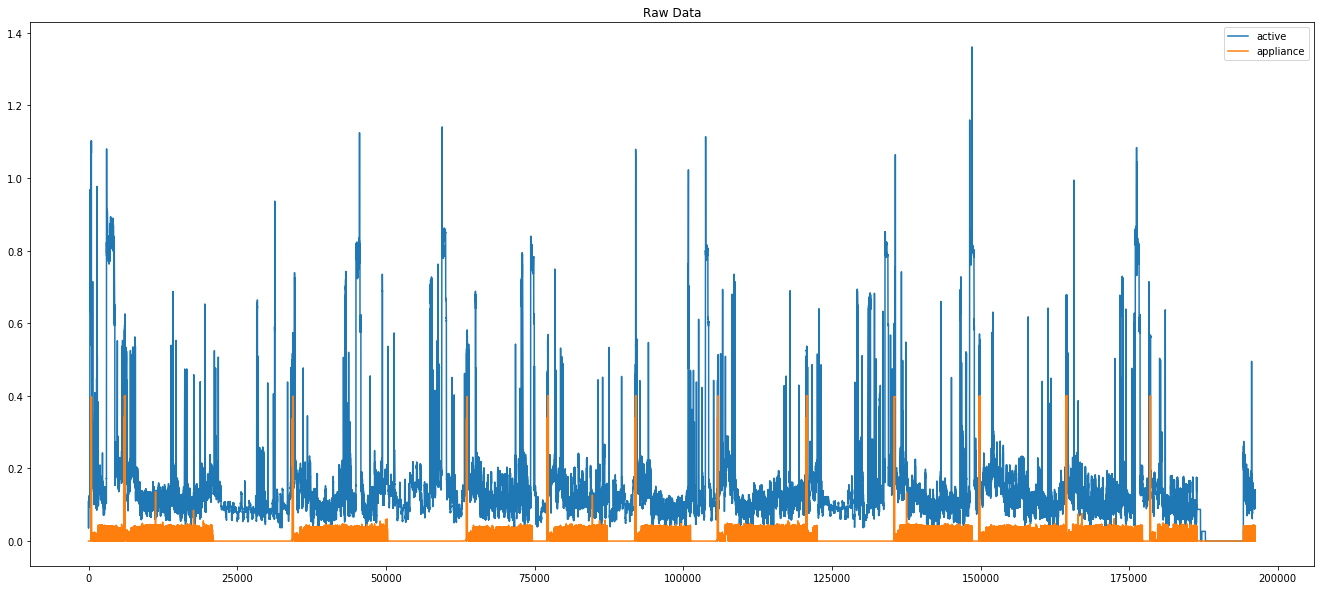

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:   53.5s finished


model fit is done..
a9      0.248079
max     0.203683
q2      0.070392
diff    0.064836
a1      0.062110
q0      0.055458
min     0.051390
std     0.038262
a0      0.020908
f9      0.018258
f1      0.018245
a8      0.017961
q1      0.016964
f6      0.012530
f5      0.012239
f4      0.011640
f7      0.009684
f3      0.009269
a7      0.007947
f8      0.006436
a6      0.006369
a2      0.006361
f2      0.006330
a4      0.005398
a3      0.005225
a5      0.005196
f0      0.004569
mean    0.004262
dtype: float64


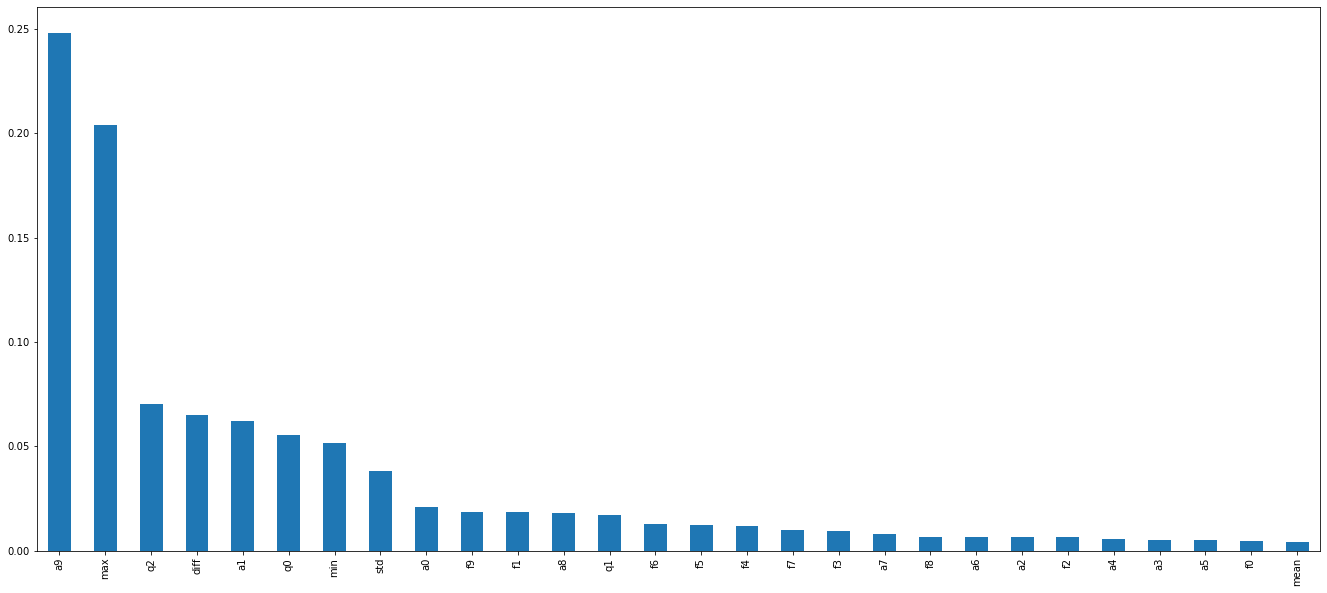

train on chunk is done..


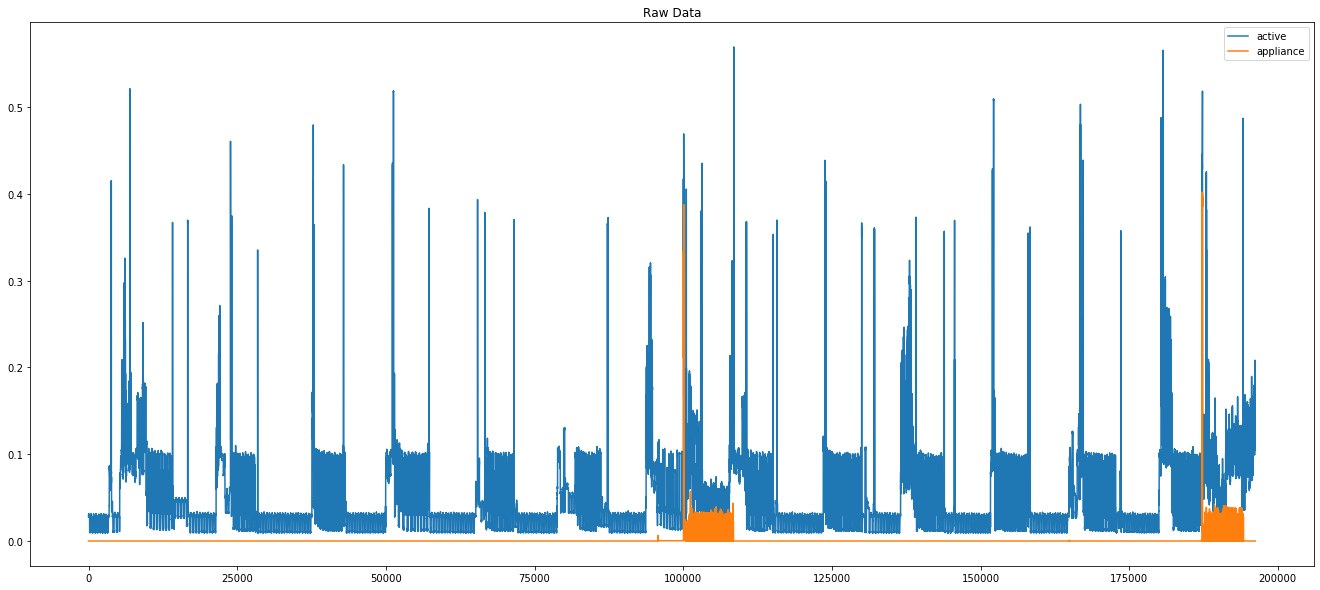

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.3min finished


model fit is done..
a9      0.173150
max     0.144669
q1      0.121579
diff    0.076636
std     0.073546
min     0.072169
q2      0.052090
a1      0.045408
q0      0.043780
f0      0.025499
a0      0.017904
f9      0.014549
mean    0.014298
a8      0.014038
f1      0.013774
f6      0.012297
f5      0.011490
f4      0.011101
a2      0.008241
f7      0.007557
f3      0.007186
a7      0.006691
f2      0.005669
a6      0.005570
a4      0.005568
f8      0.005545
a5      0.005322
a3      0.004677
dtype: float64


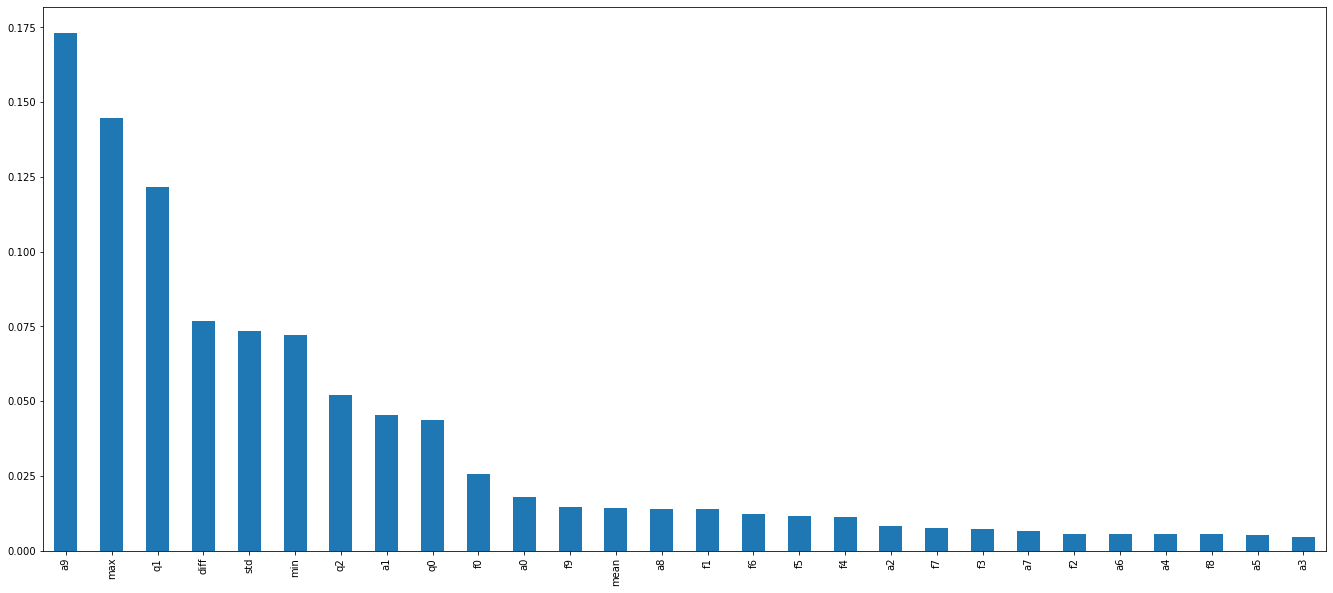

train on chunk is done..


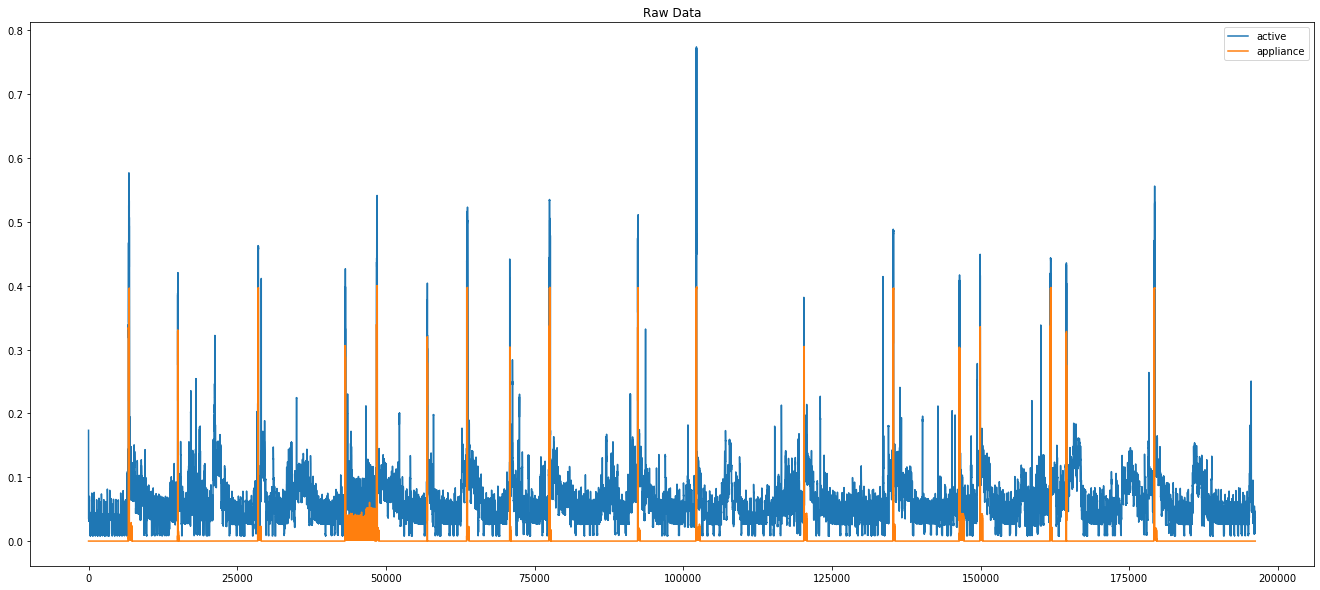

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.3min finished


model fit is done..
a9      0.358569
max     0.118250
q1      0.091458
diff    0.059138
std     0.056297
min     0.054611
q2      0.039373
a1      0.034272
q0      0.033373
f0      0.019419
a0      0.013581
f9      0.011235
a8      0.011140
mean    0.011114
f1      0.010695
f6      0.009739
f5      0.009411
f4      0.008865
a2      0.006300
f7      0.006044
f3      0.005808
a7      0.005411
f2      0.004758
f8      0.004642
a6      0.004369
a4      0.004311
a5      0.004166
a3      0.003649
dtype: float64


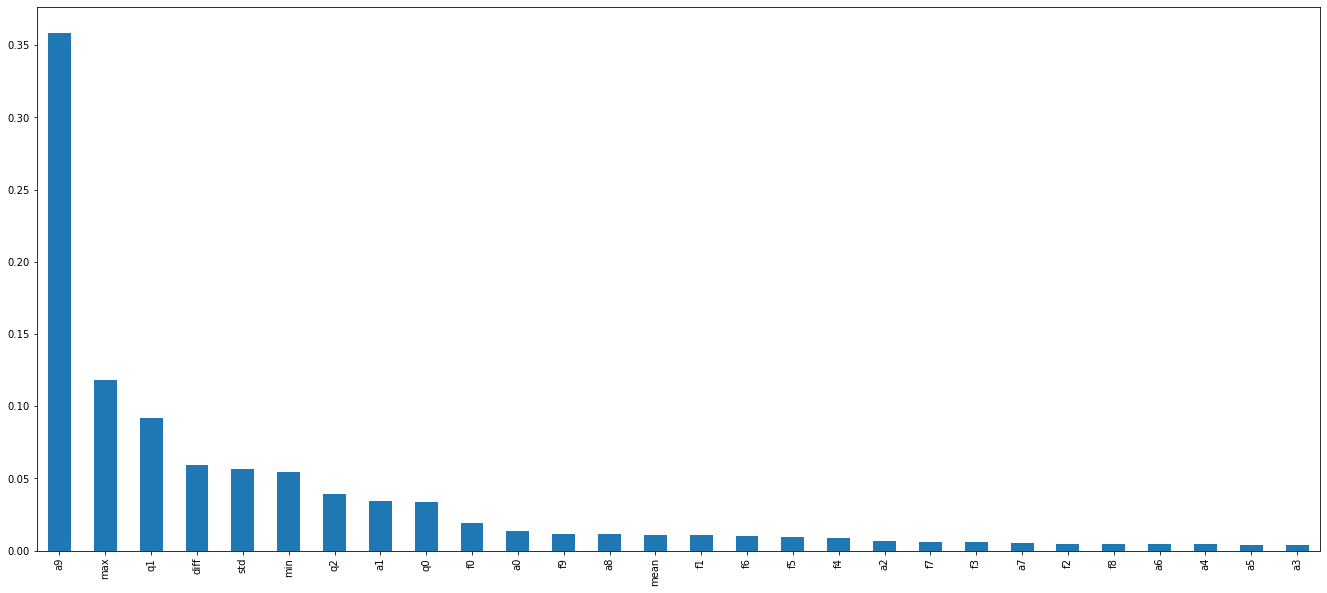

train on chunk is done..


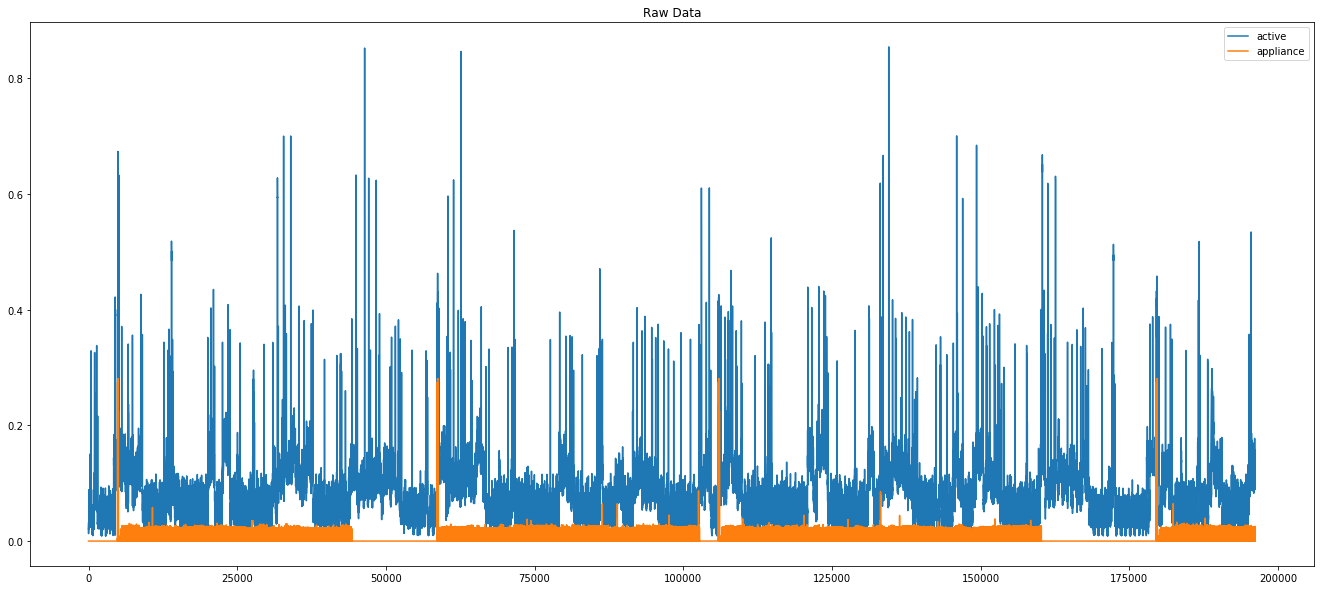

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:   48.1s finished


model fit is done..
a9      0.319430
q1      0.125519
max     0.101129
q2      0.077904
diff    0.059542
std     0.048900
min     0.046324
a1      0.029491
q0      0.027515
f0      0.016361
f6      0.012336
a0      0.012088
a8      0.011777
f4      0.011238
f9      0.011017
f5      0.010678
f1      0.010574
mean    0.009604
a4      0.007944
f7      0.006653
f3      0.006479
a2      0.006399
a7      0.006256
f2      0.005586
a6      0.005386
f8      0.005345
a5      0.004419
a3      0.004106
dtype: float64


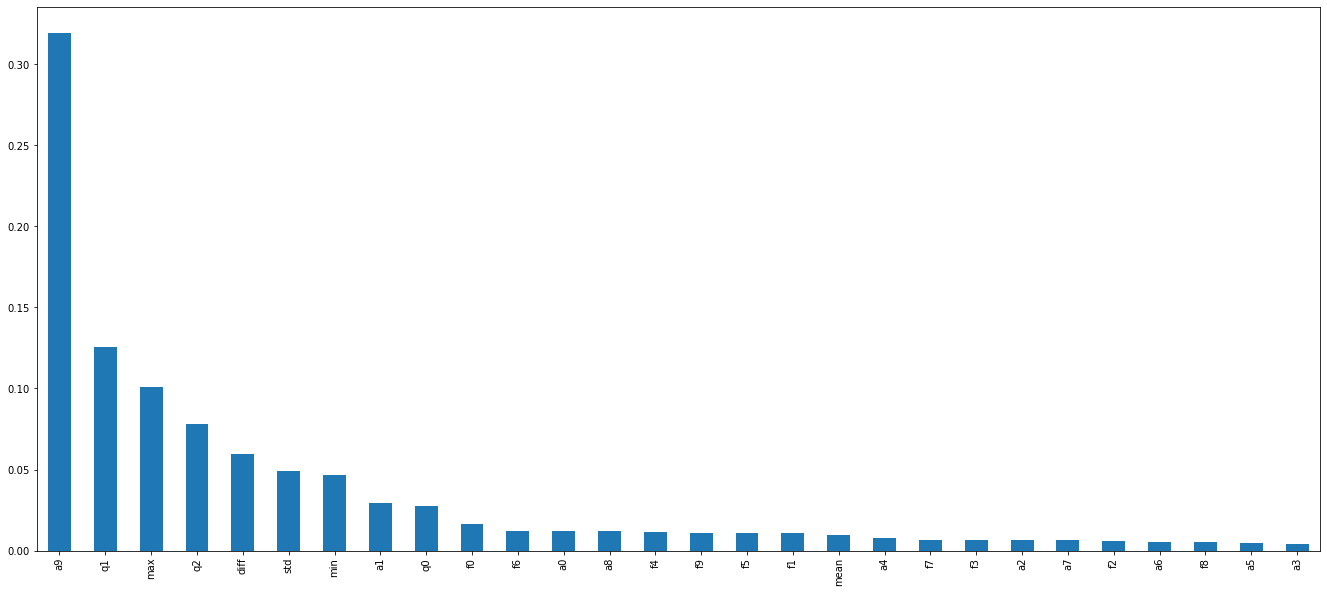

train on chunk is done..


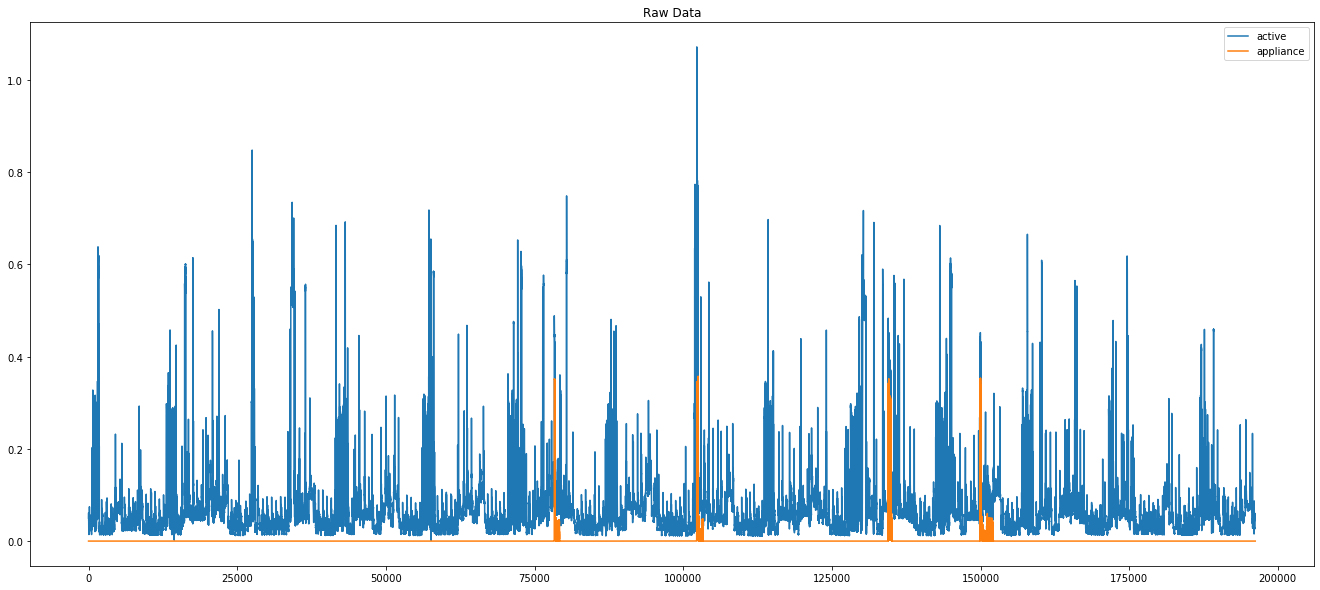

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.2min finished


model fit is done..
a9      0.293911
max     0.127639
q1      0.109491
q2      0.073394
diff    0.061753
min     0.050656
std     0.043908
q0      0.027912
a1      0.025989
f4      0.023800
f6      0.022819
f0      0.015130
a8      0.013299
a0      0.011998
f5      0.010686
f9      0.009967
f1      0.009628
mean    0.008797
a4      0.007236
a7      0.006989
a6      0.006729
f7      0.006175
a2      0.006087
f3      0.006030
f2      0.005766
f8      0.005253
a5      0.004799
a3      0.004160
dtype: float64


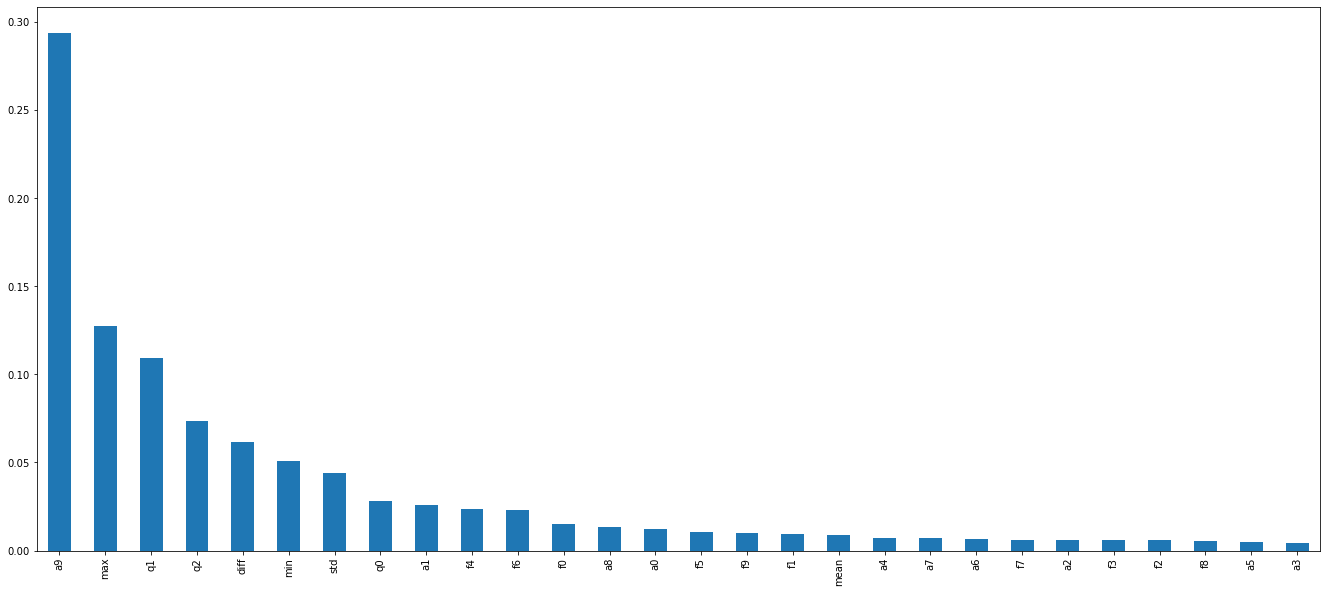

train on chunk is done..


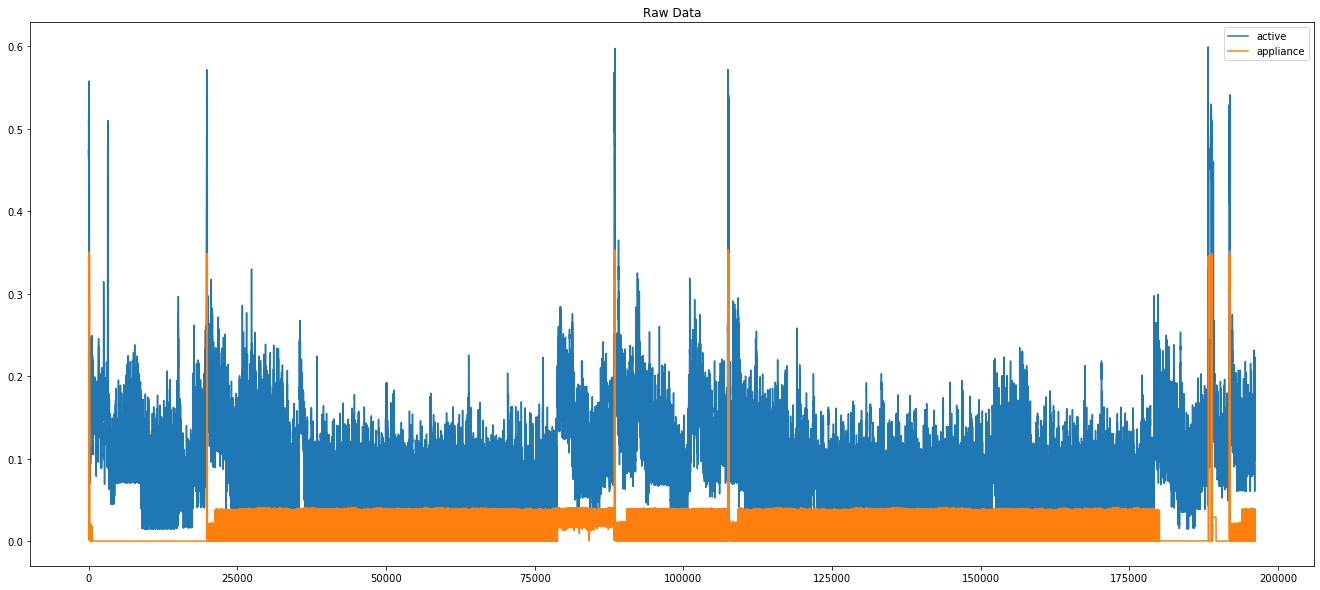

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:   53.6s finished


model fit is done..
a9      0.335547
max     0.111483
q1      0.095206
diff    0.066365
q2      0.065620
min     0.047166
std     0.046077
q0      0.025382
f4      0.023591
a1      0.023276
f6      0.022749
f0      0.013289
a8      0.013104
a0      0.011453
f5      0.010985
f9      0.009497
f1      0.009214
mean    0.007792
a7      0.007255
a6      0.007219
a4      0.007114
f2      0.006532
f7      0.006363
f3      0.006247
f8      0.006115
a2      0.005864
a5      0.004872
a3      0.004624
dtype: float64


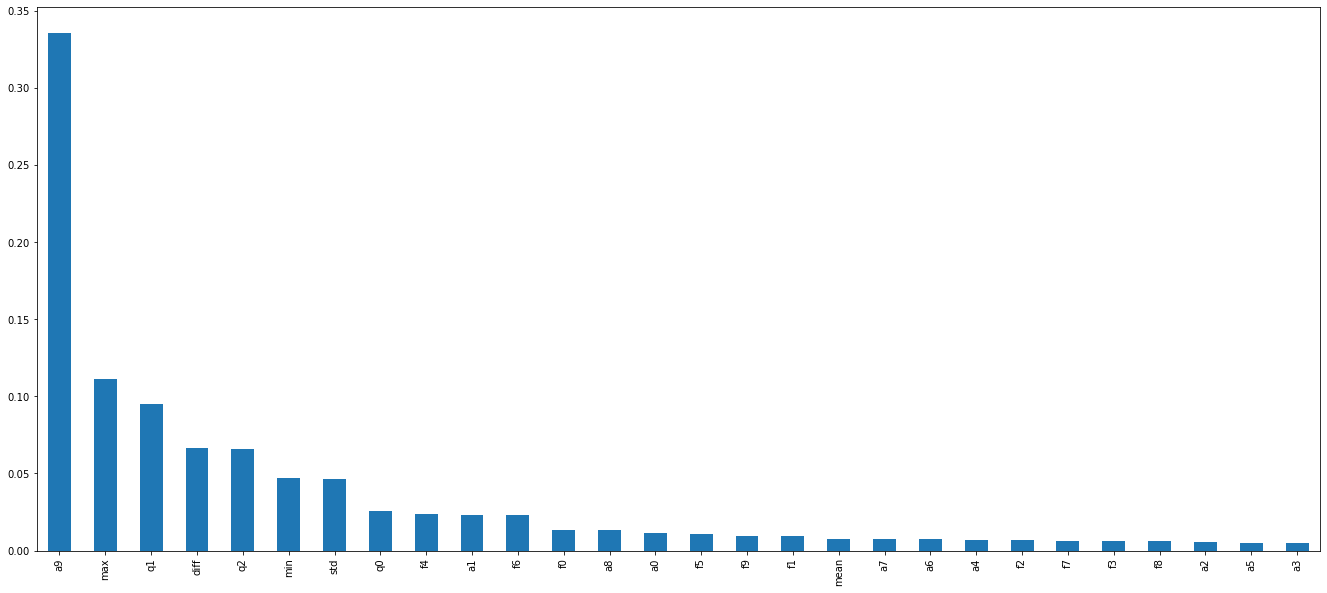

train on chunk is done..


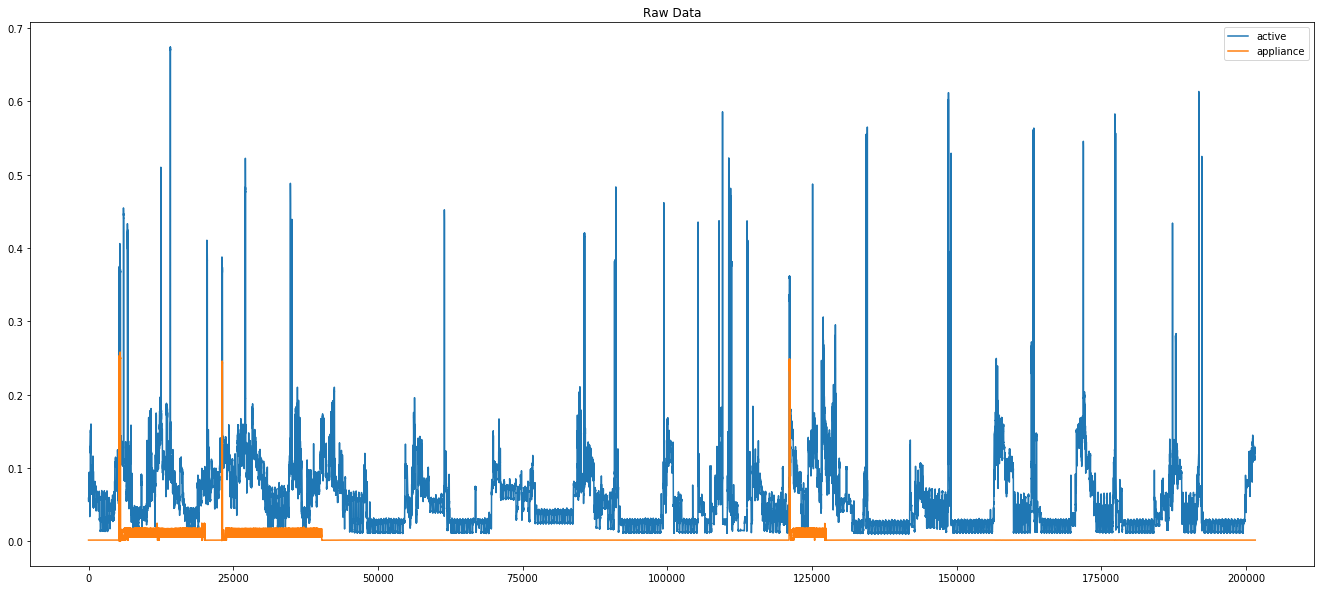

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.1min finished


model fit is done..
a9      0.296801
max     0.116424
q1      0.091857
min     0.083632
diff    0.067174
q2      0.057960
q0      0.050145
std     0.041205
f4      0.021750
f6      0.021021
a1      0.020876
a8      0.013806
f0      0.011818
a0      0.010508
f5      0.010422
f9      0.008687
f1      0.008470
mean    0.007492
a7      0.007041
a6      0.006534
a4      0.006501
f7      0.006204
f2      0.006182
f3      0.006076
f8      0.005796
a2      0.005372
a3      0.005352
a5      0.004895
dtype: float64


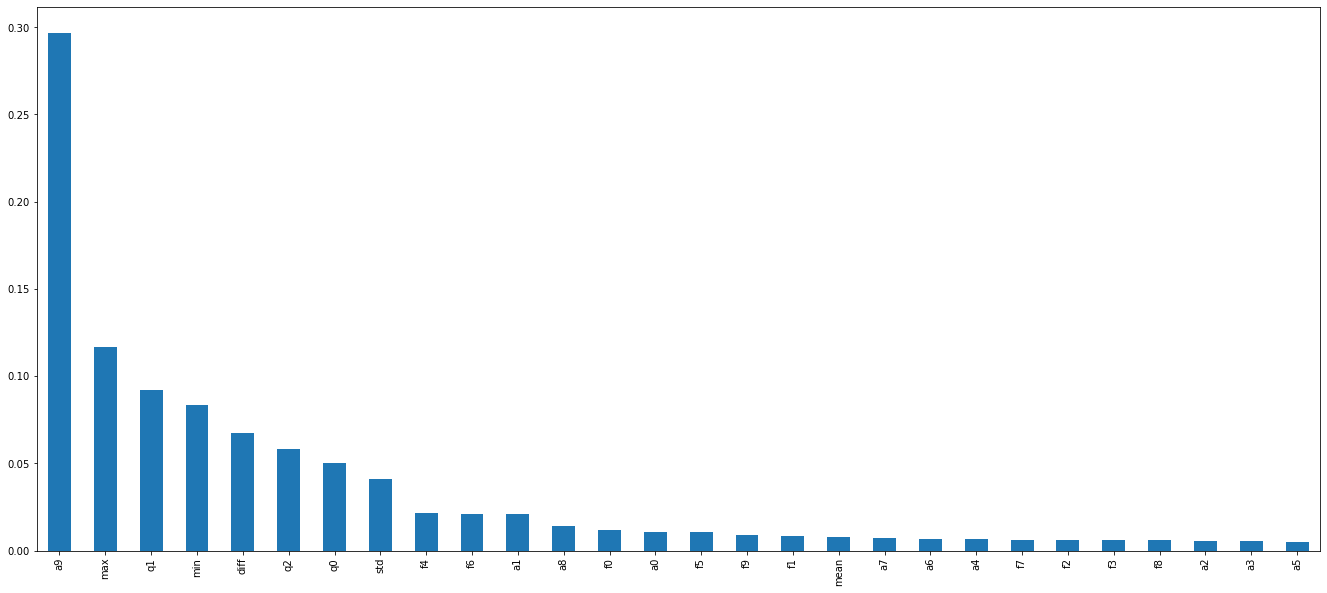

train on chunk is done..


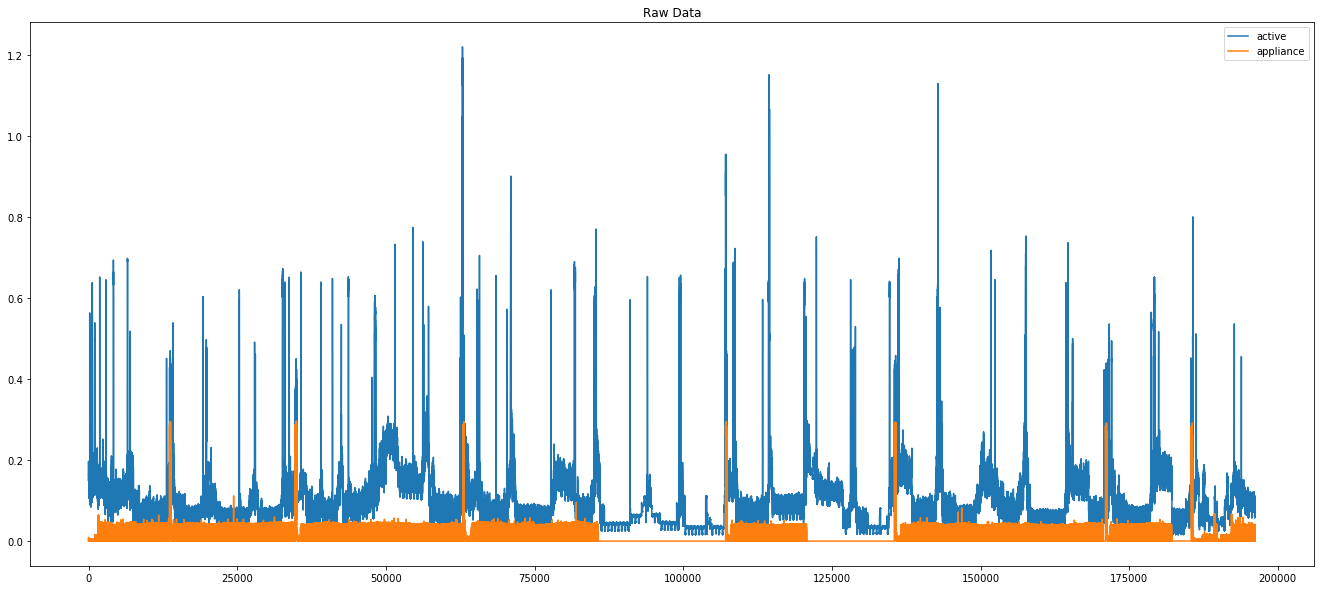

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:   48.3s finished


model fit is done..
a9      0.307878
max     0.124660
q1      0.082601
min     0.077919
diff    0.066713
q2      0.053726
q0      0.046326
std     0.038155
f4      0.023625
f6      0.023213
a1      0.020478
a8      0.015628
f5      0.011028
f0      0.011015
a0      0.010062
f1      0.009200
f9      0.009031
a7      0.007703
mean    0.007027
a4      0.006741
a6      0.006632
f7      0.006185
f2      0.006133
f3      0.006077
a2      0.005778
f8      0.005755
a3      0.005534
a5      0.005174
dtype: float64


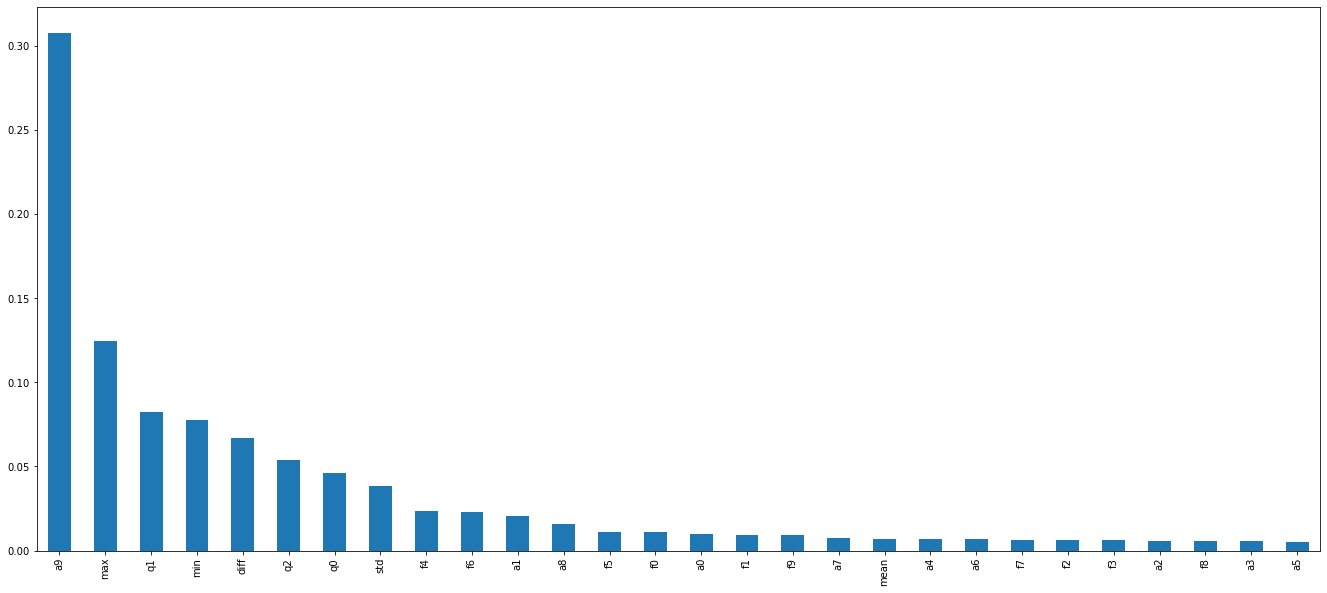

train on chunk is done..


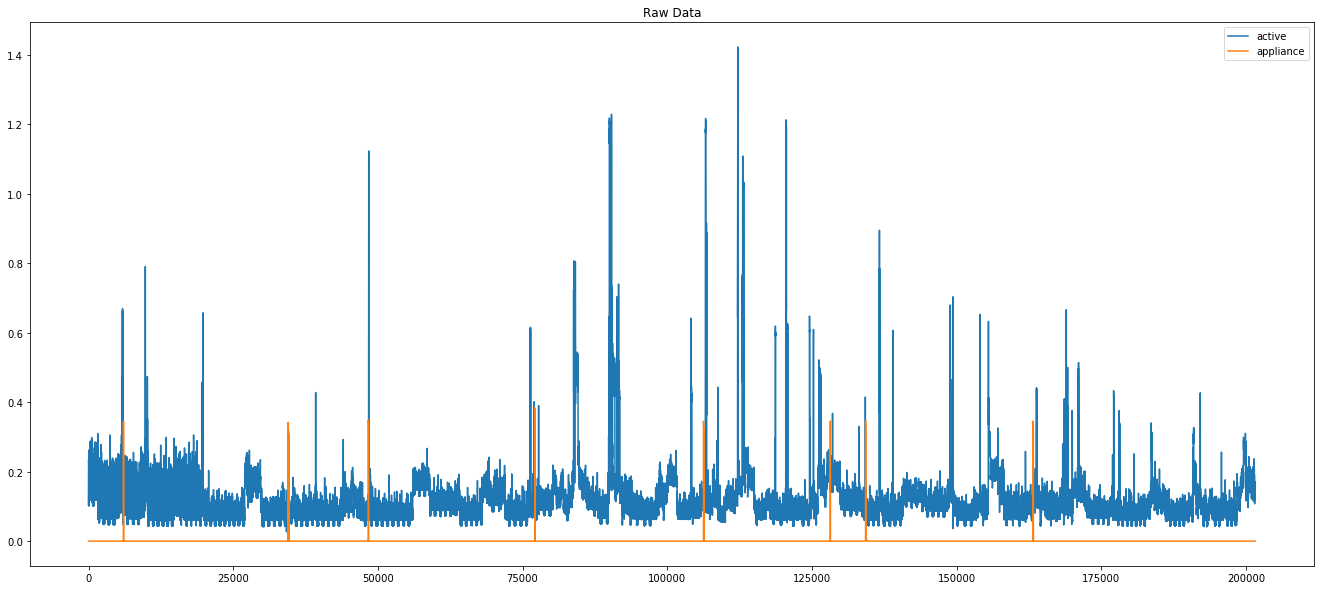

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.2min finished


model fit is done..
a9      0.279485
max     0.120355
min     0.097120
q1      0.078597
diff    0.064070
q2      0.053615
q0      0.048323
std     0.037024
f4      0.022561
f6      0.022407
a1      0.021061
a8      0.016788
f5      0.012111
a0      0.011199
f0      0.011181
f1      0.009916
f9      0.009716
a7      0.009705
a4      0.008548
a6      0.008530
a3      0.007695
a2      0.007440
mean    0.007405
f2      0.007384
f8      0.006986
a5      0.006950
f3      0.006918
f7      0.006911
dtype: float64


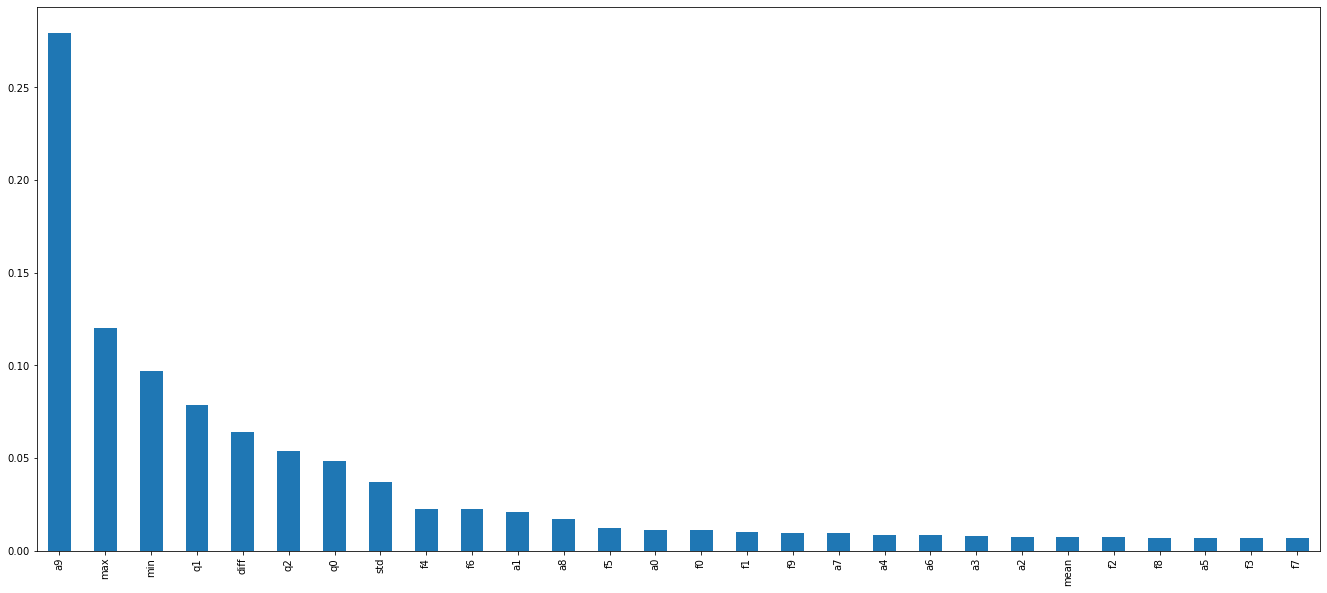

train on chunk is done..
elapsed time (secs) = 1778.8191652297974


In [358]:
dataset = DataSet(DATA_FILE)

# pre-trained model
model = DTDisaggregator(algorithm='DRF', use_feature=True, reactive=False)

start = time.time()

dataset.set_window(start='2017-01-01 00:00:00', end='2017-01-15 00:00:00')

train_elec = dataset.buildings[1].elec
train_mains = train_elec.all_meters()[0]
train_meter = train_elec.submeters()['rice cooker']

model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)

for home_id in [2,10,13,14,18,22]:    
    train_elec = dataset.buildings[home_id].elec
    train_mains = train_elec.all_meters()[0]
    train_meter = train_elec.submeters()['rice cooker']

    model.add_trees()
    model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)

dataset.set_window(start='2016-10-01 00:00:00', end='2016-10-15 00:00:00')
for home_id in [5]:    
    train_elec = dataset.buildings[home_id].elec
    train_mains = train_elec.all_meters()[0]
    train_meter = train_elec.submeters()['rice cooker']

    model.add_trees()
    model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)

dataset.set_window(start='2017-04-01 00:00:00', end='2017-04-15 00:00:00')
for home_id in [12,21]:    
    train_elec = dataset.buildings[home_id].elec
    train_mains = train_elec.all_meters()[0]
    train_meter = train_elec.submeters()['rice cooker']

    model.add_trees()
    model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
    
end = time.time()            
print("elapsed time (secs) = " + str(end-start))

New sensible chunk: 196200
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    1.2s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    2.2s
[Parallel(n_jobs=32)]: Done 1000 out of 1000 | elapsed:    3.0s finished


Disaggregation is done..
============ Relative error in total energy: 0.3358095625601901
============ Mean absolute error(in Watts): 20.52025694689513
============ Recall: 0.9686814186117005
============ Precision: 0.6080431076473454
============ Accuracy: 0.7243476044852192
============ F1 Score: 0.7471185362865705
196200
196200
upper = 21.435572819560768
least_amount = 7.929495840112368
precision = 0.9759036144578314
# of peaks = 83
activations : [0, 600, 6000, 16200, 17400, 20400, 34200, 36600, 37200, 49200, 49800, 51600, 52200, 52800, 57600, 72000, 72600, 73800, 79200, 79800, 80400, 81000, 81600, 82200, 82800, 93600, 94200, 95400, 102000, 106800, 107400, 108000, 108600, 109200, 115200, 118800, 121200, 123000, 123600, 124200, 124800, 125400, 126000, 126600, 127200, 129600, 130200, 132000, 136800, 137400, 146400, 150600, 151200, 151800, 158400, 160800, 161400, 164400, 173400, 175800, 176400, 177600, 178200, 178800, 179400, 180000, 180600, 181200, 181800, 182400, 183000, 183600, 18420

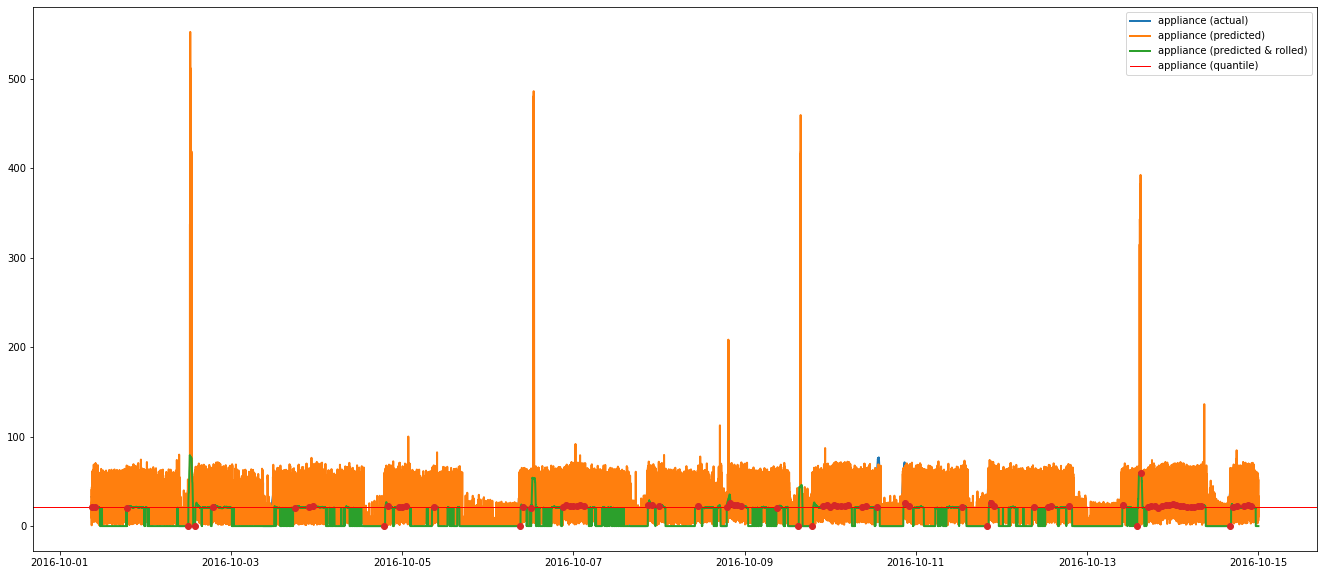

New sensible chunk: 201600
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.9s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    1.9s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    3.3s
[Parallel(n_jobs=32)]: Done 1000 out of 1000 | elapsed:    4.5s finished


Disaggregation is done..
============ Relative error in total energy: 0.1572221462992322
============ Mean absolute error(in Watts): 41.104795962892744
============ Recall: 0.7605973877296144
============ Precision: 0.5940804929400002
============ Accuracy: 0.6382043650793651
============ F1 Score: 0.6671048187602121
201600
201600
upper = 24.536480617796382
least_amount = 42.560780934651696
precision = 0.8275862068965517
# of peaks = 87
activations : [4200, 4800, 5400, 6000, 11400, 12000, 13800, 21600, 22200, 24600, 25200, 34800, 35400, 37800, 39000, 40200, 41400, 50400, 52800, 54000, 54600, 62400, 64200, 68400, 69000, 70200, 70800, 71400, 78600, 79200, 80400, 81000, 81600, 82200, 85200, 85800, 91200, 93600, 97200, 97800, 98400, 99600, 109200, 109800, 110400, 113400, 114600, 120000, 123000, 123600, 124200, 124800, 125400, 128400, 138000, 139800, 142200, 142800, 143400, 150000, 150600, 151200, 154800, 155400, 157200, 157800, 165000, 165600, 168600, 169200, 169800, 171000, 171600, 178200

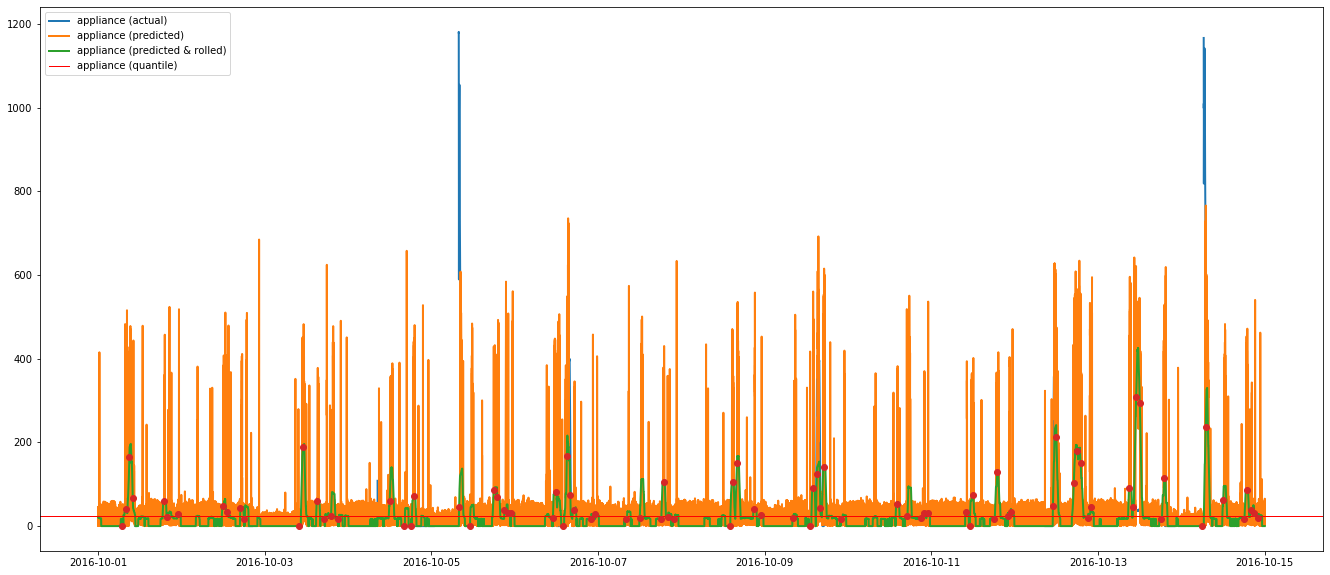

New sensible chunk: 196200
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    2.4s
[Parallel(n_jobs=32)]: Done 1000 out of 1000 | elapsed:    3.0s finished


Disaggregation is done..
============ Relative error in total energy: 0.7989782745969509
============ Mean absolute error(in Watts): 10.743564773023717
============ Recall: 0.4629101283880171
============ Precision: 0.027451726836283653
============ Accuracy: 0.7579459734964322
============ F1 Score: 0.051829816119951286
196200
196200
upper = 13.495909288252394
least_amount = 18.60913653898239
precision = 0.037037037037037035
# of peaks = 81
activations : [0, 600, 1200, 3600, 6600, 7200, 7800, 12600, 21000, 27600, 36000, 42000, 42600, 49800, 50400, 56400, 57000, 63600, 64200, 64800, 70800, 72000, 79800, 80400, 85800, 86400, 87000, 87600, 88200, 88800, 89400, 90000, 90600, 91200, 91800, 92400, 93000, 95400, 100800, 101400, 102000, 102600, 103200, 103800, 104400, 105000, 105600, 106200, 106800, 107400, 108600, 114000, 114600, 121200, 121800, 128400, 129000, 136200, 136800, 137400, 142800, 143400, 148800, 149400, 150000, 150600, 151200, 151800, 156600, 157200, 157800, 165000, 165600, 1716

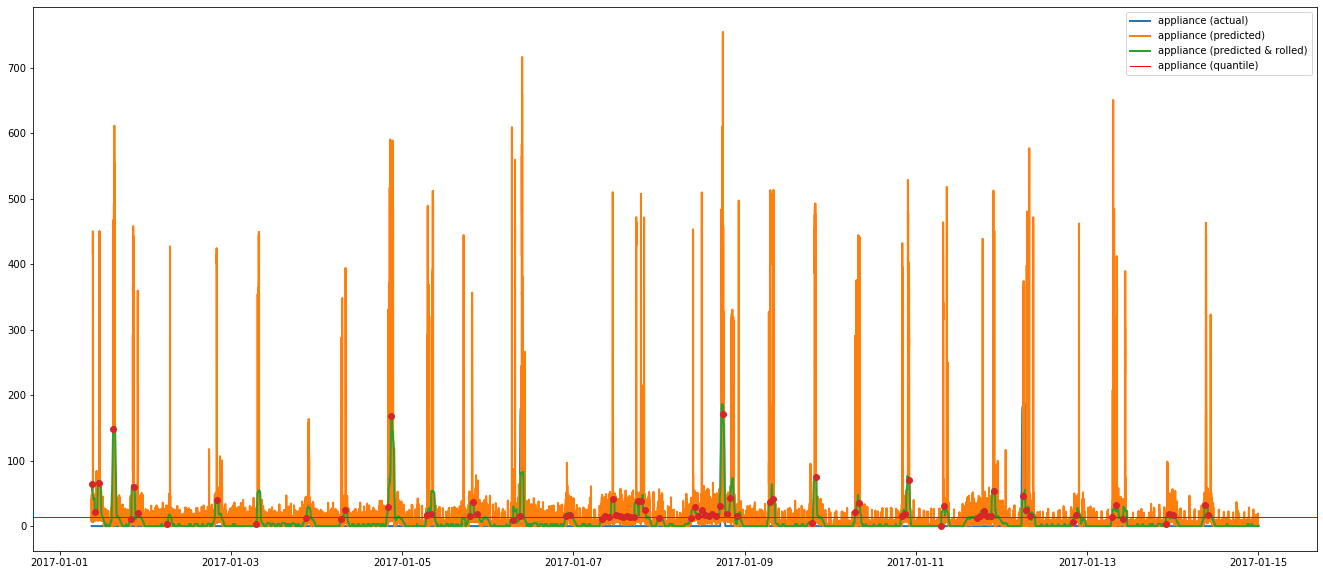

81

In [359]:
disaggregate(dataset, model, 3, 'rice cooker', '2016-10-01 00:00:00', '2016-10-15 00:00:00', True)
disaggregate(dataset, model, 6, 'rice cooker', '2016-10-01 00:00:00', '2016-10-15 00:00:00', True)
disaggregate(dataset, model, 9, 'rice cooker', '2017-01-01 00:00:00', '2017-01-15 00:00:00', True)

### Chaining

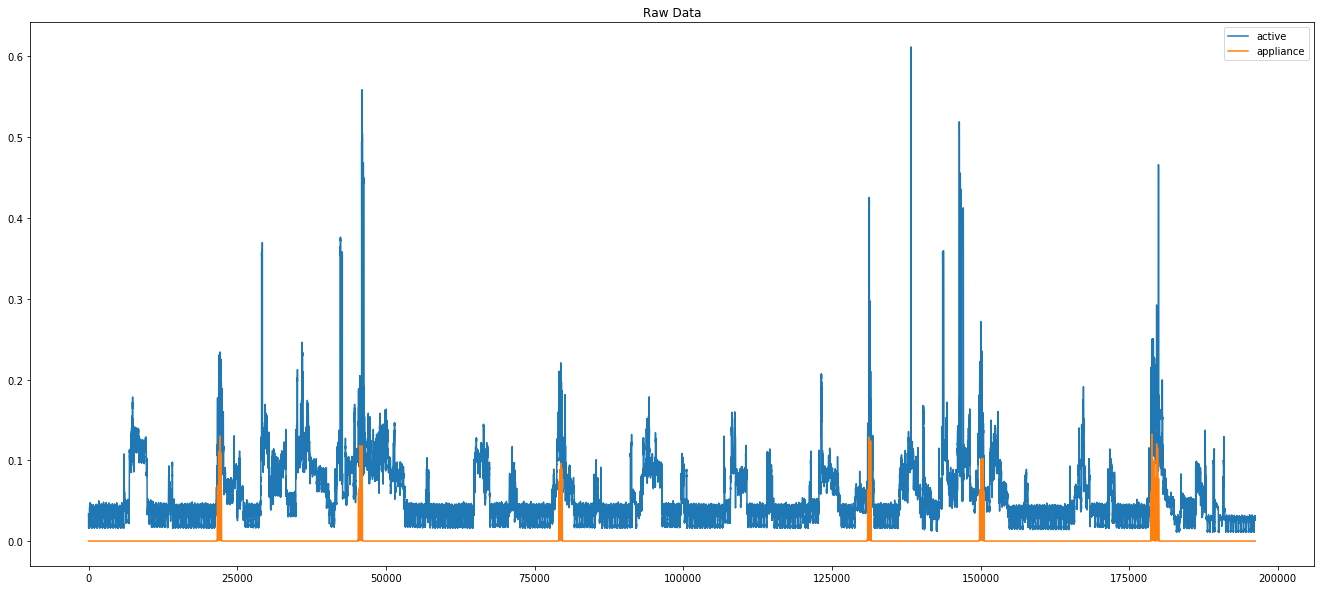

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.2min finished


model fit is done..
a9      0.281584
max     0.119014
min     0.093696
diff    0.072875
q1      0.072789
q2      0.052344
q0      0.045898
std     0.036632
f4      0.021528
f6      0.021514
a1      0.020533
a8      0.017934
f5      0.013049
a0      0.012674
f0      0.010925
a7      0.010041
f1      0.009963
f9      0.009782
a4      0.008825
a6      0.008736
a3      0.007998
a2      0.007788
f2      0.007548
mean    0.007507
a5      0.007479
f8      0.007198
f7      0.007103
f3      0.007041
dtype: float64


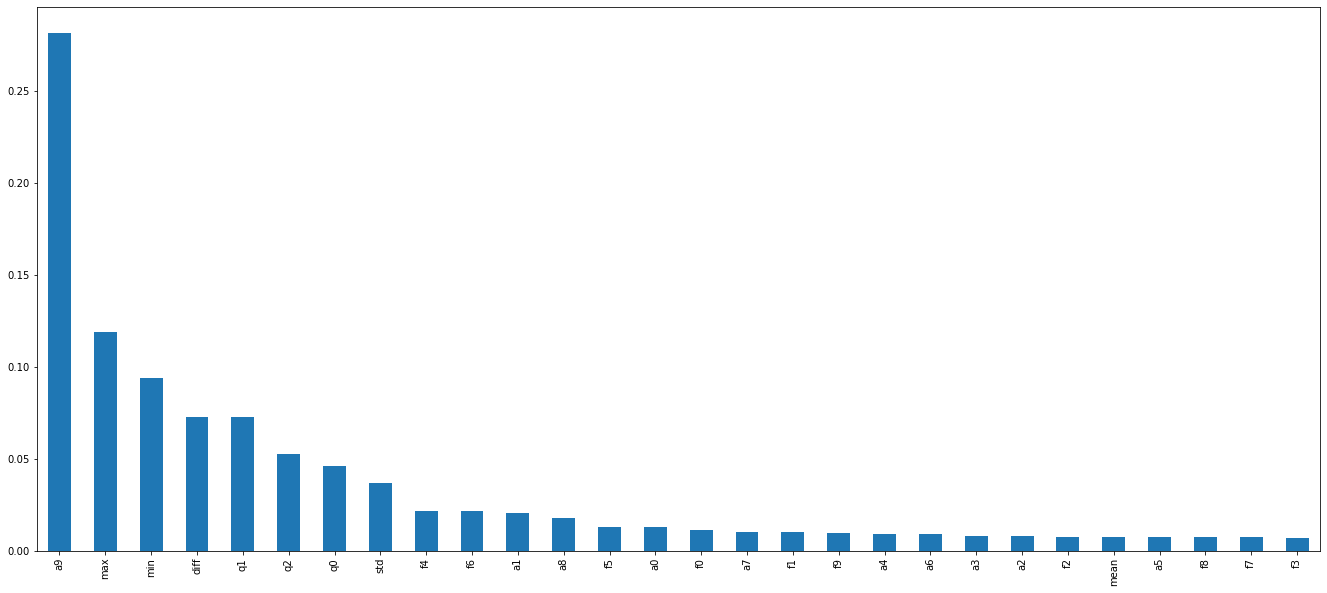

train on chunk is done..


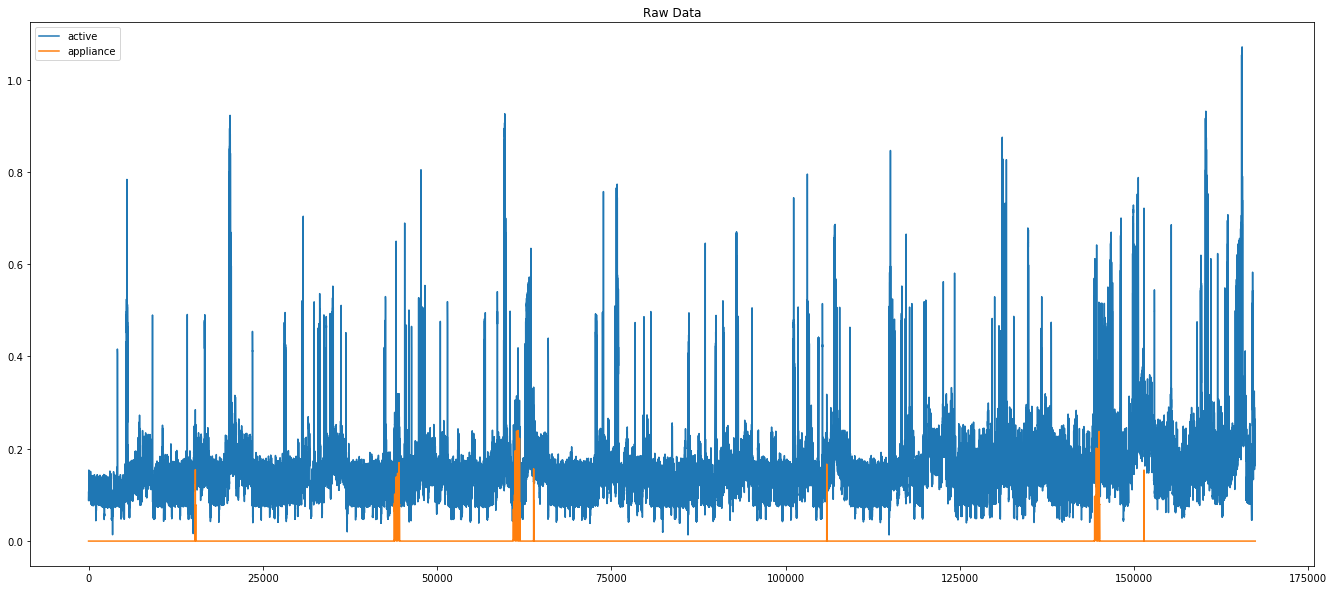

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.1min finished


model fit is done..
a9      0.262616
max     0.117309
min     0.090636
diff    0.073107
q1      0.069472
q2      0.051353
q0      0.044926
std     0.038002
f6      0.021940
f4      0.021814
a1      0.021577
a8      0.019208
f5      0.017608
a0      0.013863
a7      0.011669
f0      0.011041
f1      0.010721
f9      0.010533
a4      0.010472
a6      0.010439
a3      0.009832
a2      0.009680
f7      0.009294
f3      0.009258
a5      0.008912
f2      0.008642
f8      0.008211
mean    0.007864
dtype: float64


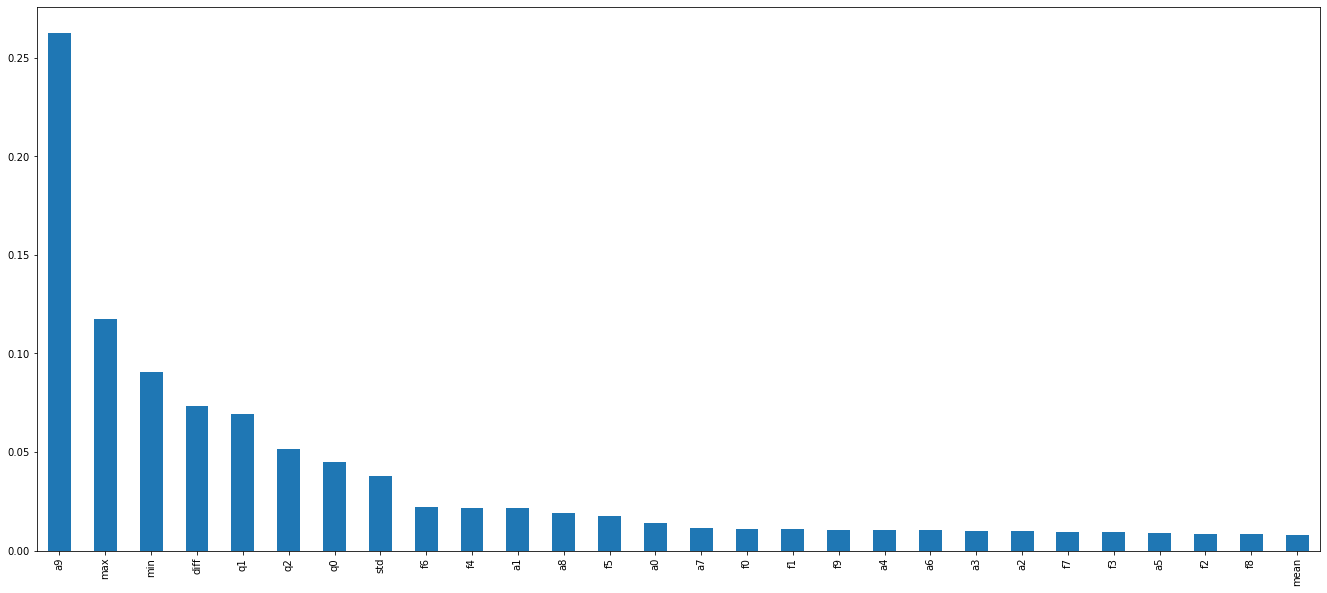

train on chunk is done..


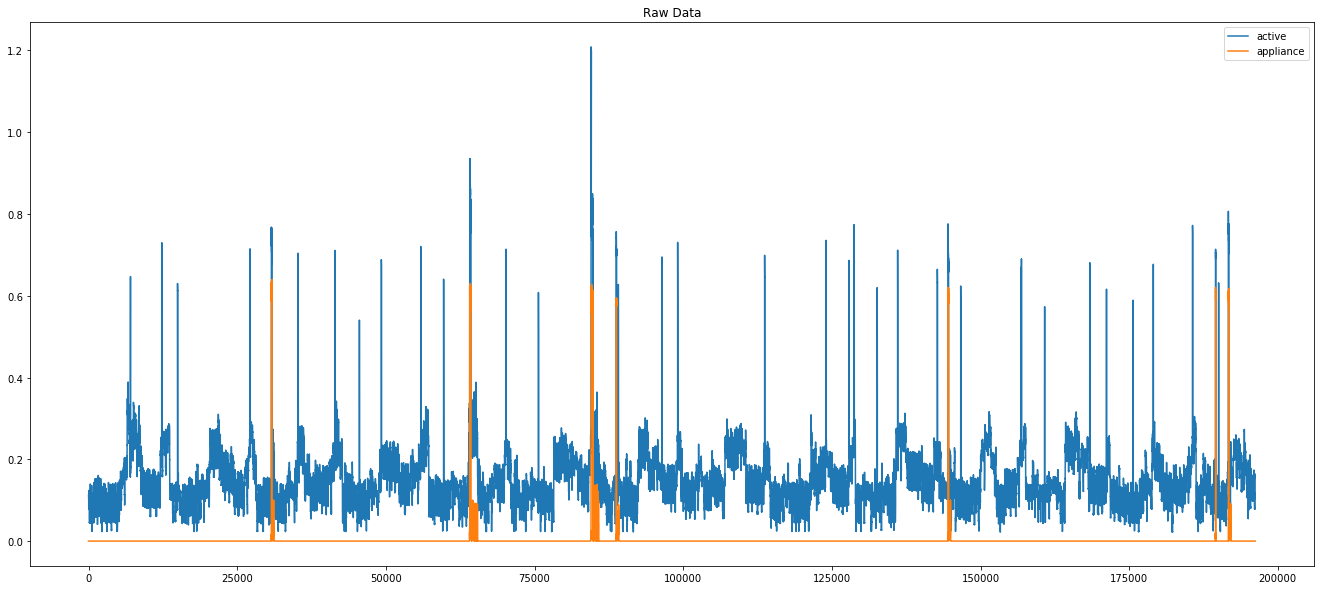

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.7min finished


model fit is done..
a9      0.250830
max     0.108597
min     0.084463
diff    0.071692
q1      0.064829
q2      0.047595
q0      0.041674
std     0.039891
mean    0.037200
f0      0.031821
f6      0.020578
f4      0.020467
a1      0.020113
a8      0.019210
f5      0.017254
a0      0.013170
a7      0.010891
f1      0.010064
f9      0.009885
a4      0.009784
a6      0.009749
a3      0.009233
a2      0.009079
f3      0.008873
f7      0.008829
a5      0.008371
f2      0.008124
f8      0.007734
dtype: float64


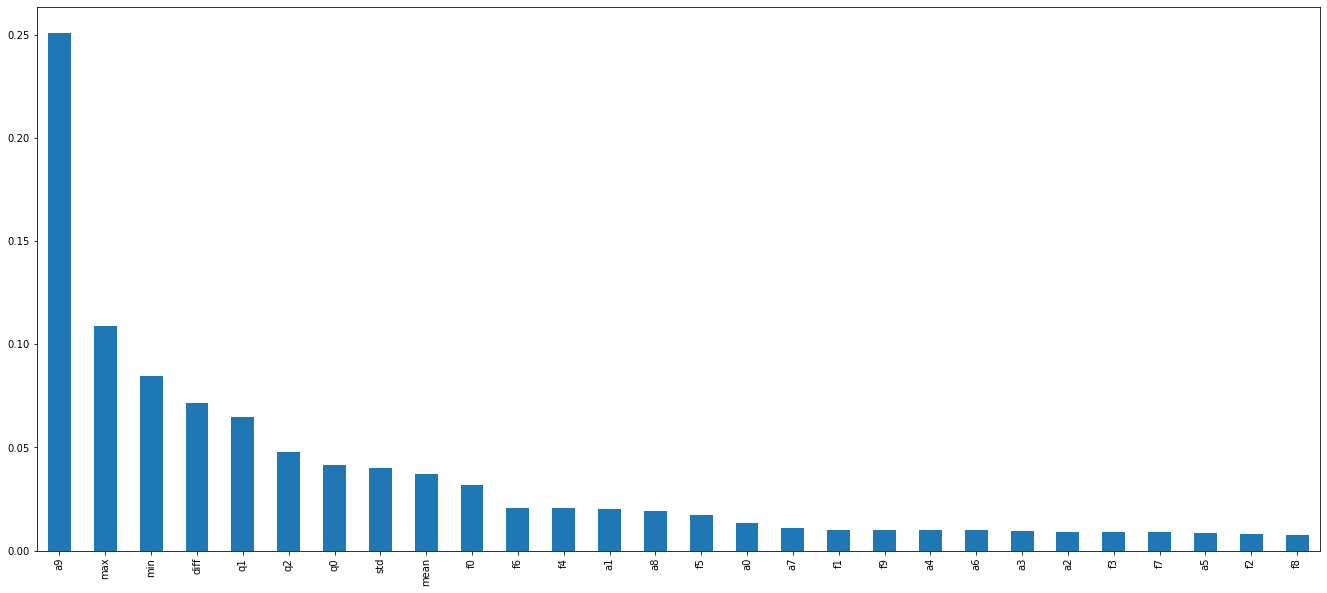

train on chunk is done..


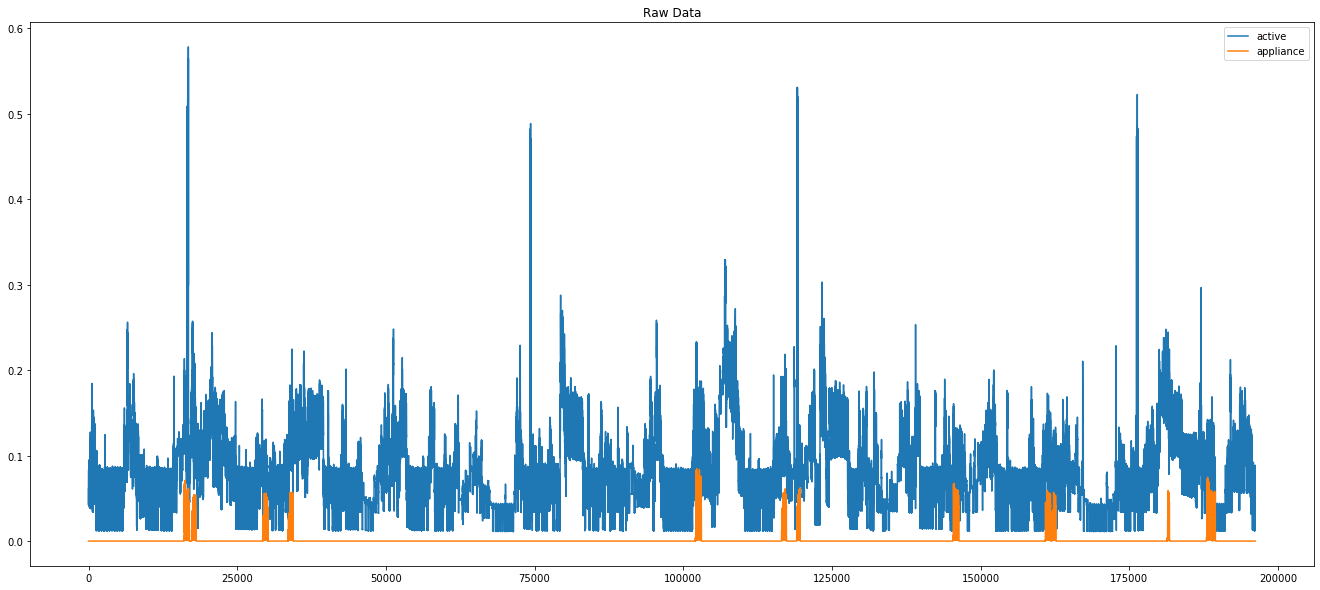

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.0min finished


model fit is done..
a9      0.236063
max     0.108750
min     0.083875
diff    0.073815
q1      0.064815
q2      0.048242
q0      0.041726
std     0.041421
mean    0.035481
f0      0.030484
f6      0.020485
a1      0.020462
f4      0.020423
f5      0.020104
a8      0.019564
a0      0.014030
a7      0.011683
f1      0.010785
f9      0.010653
a4      0.010579
a6      0.010579
a3      0.010200
a2      0.009981
f3      0.009771
f7      0.009668
a5      0.009181
f2      0.008777
f8      0.008404
dtype: float64


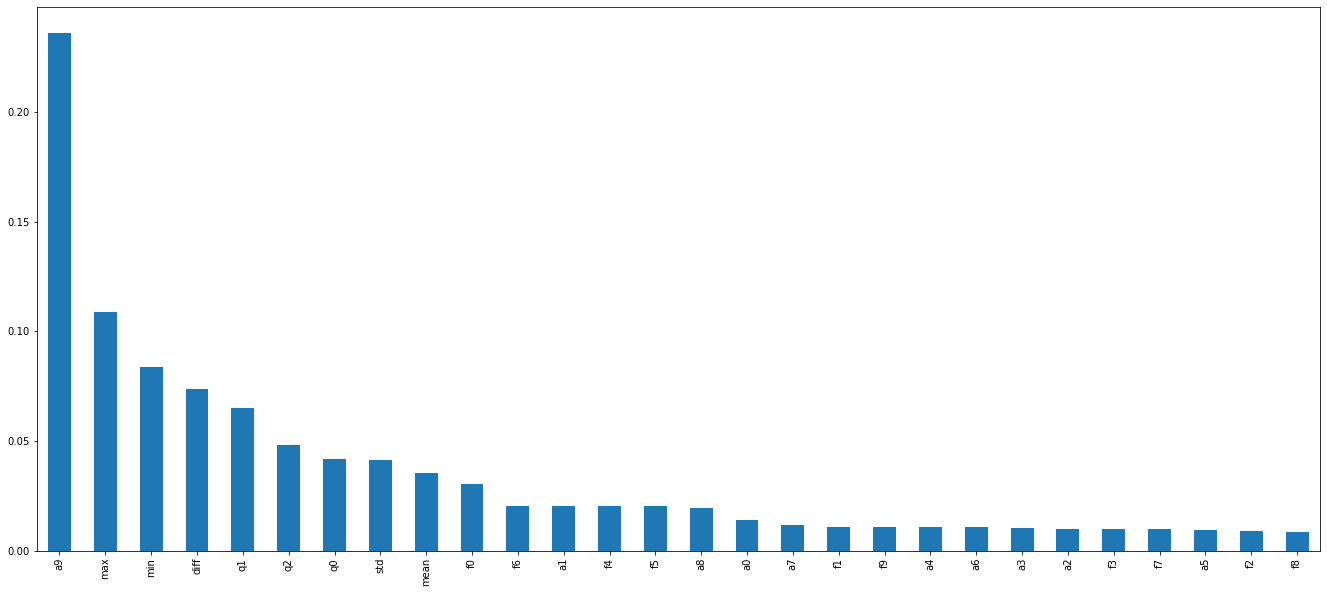

train on chunk is done..


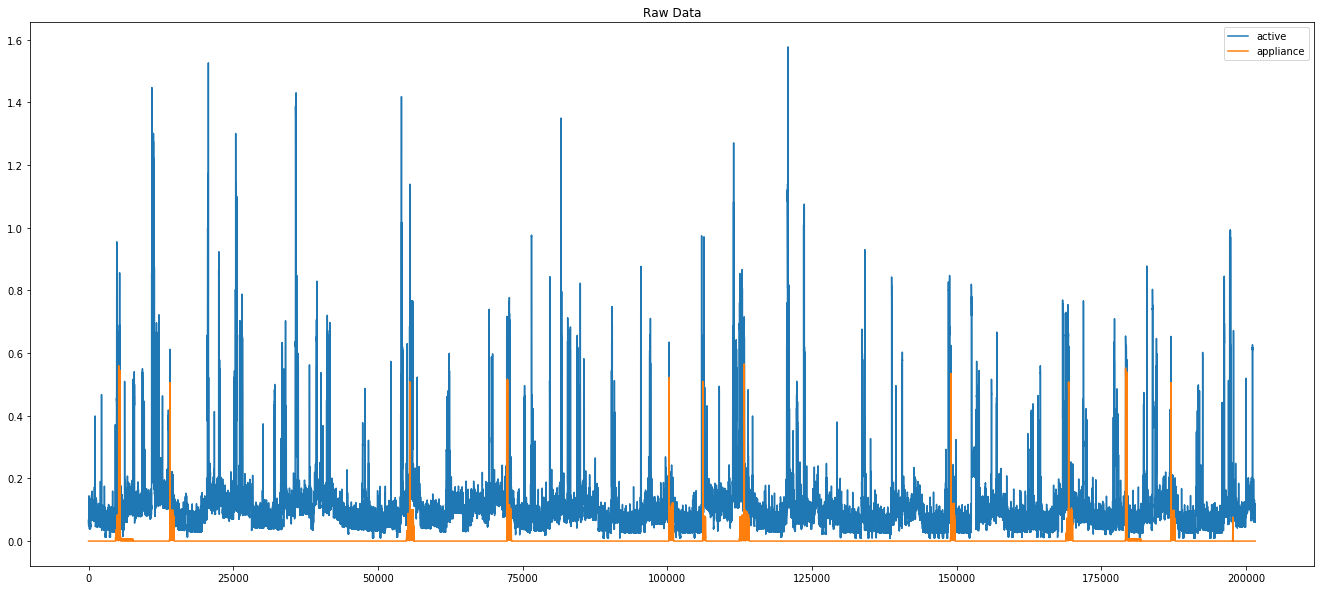

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.1min finished


model fit is done..
a9      0.237508
max     0.105197
min     0.086734
diff    0.072678
q1      0.063454
q2      0.046851
std     0.043785
q0      0.041903
mean    0.033648
f0      0.029057
a1      0.021203
f5      0.020809
f6      0.019806
f4      0.019784
a8      0.019739
a0      0.015553
a7      0.011819
f1      0.011009
f9      0.010885
a4      0.010776
a6      0.010672
a3      0.010341
a2      0.010230
f3      0.009683
f7      0.009623
a5      0.009367
f2      0.009140
f8      0.008746
dtype: float64


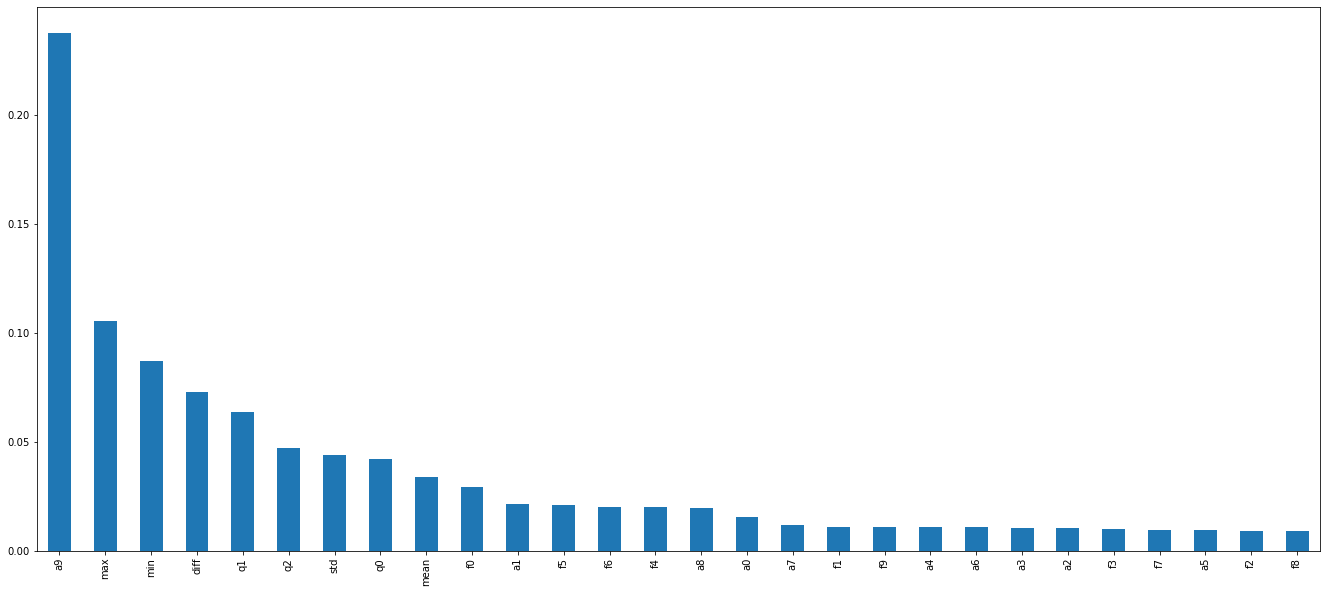

train on chunk is done..


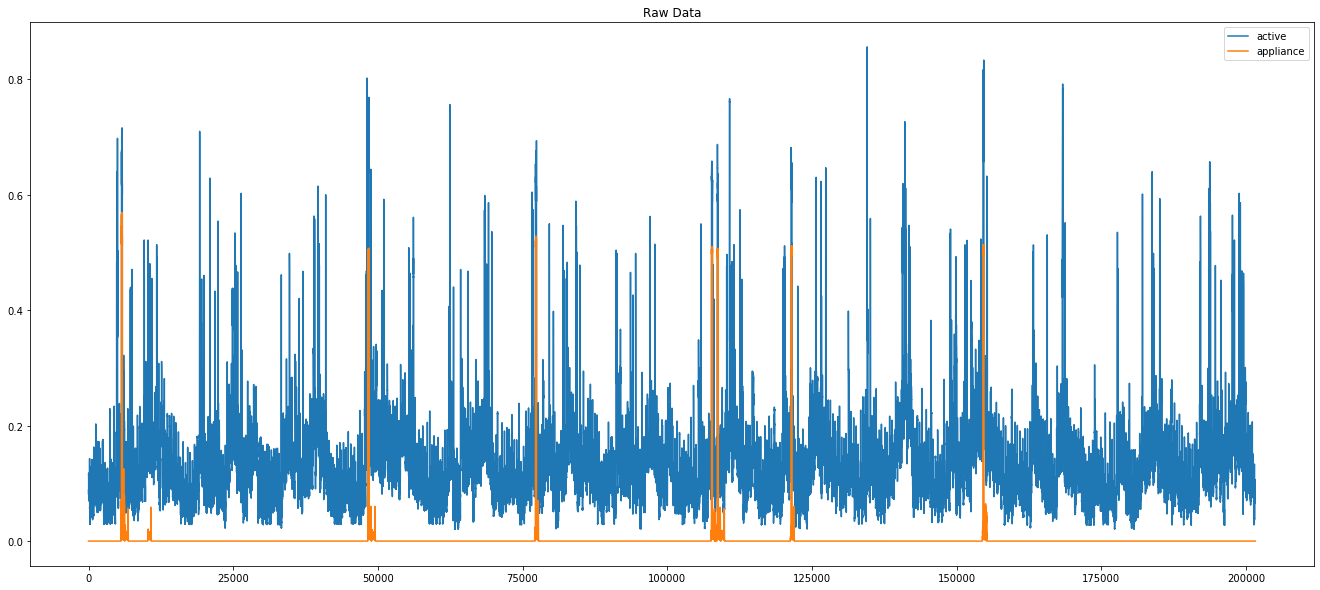

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.4min finished


model fit is done..
a9      0.224058
min     0.138471
max     0.099116
diff    0.069401
q1      0.059629
q2      0.044096
std     0.041249
q0      0.039538
mean    0.031592
f0      0.027280
a1      0.019943
f5      0.019678
a8      0.018715
f4      0.018647
f6      0.018642
a0      0.014644
a7      0.011159
f1      0.010360
f9      0.010253
a4      0.010147
a6      0.010114
a3      0.009740
a2      0.009654
f3      0.009116
f7      0.009066
a5      0.008820
f2      0.008613
f8      0.008256
dtype: float64


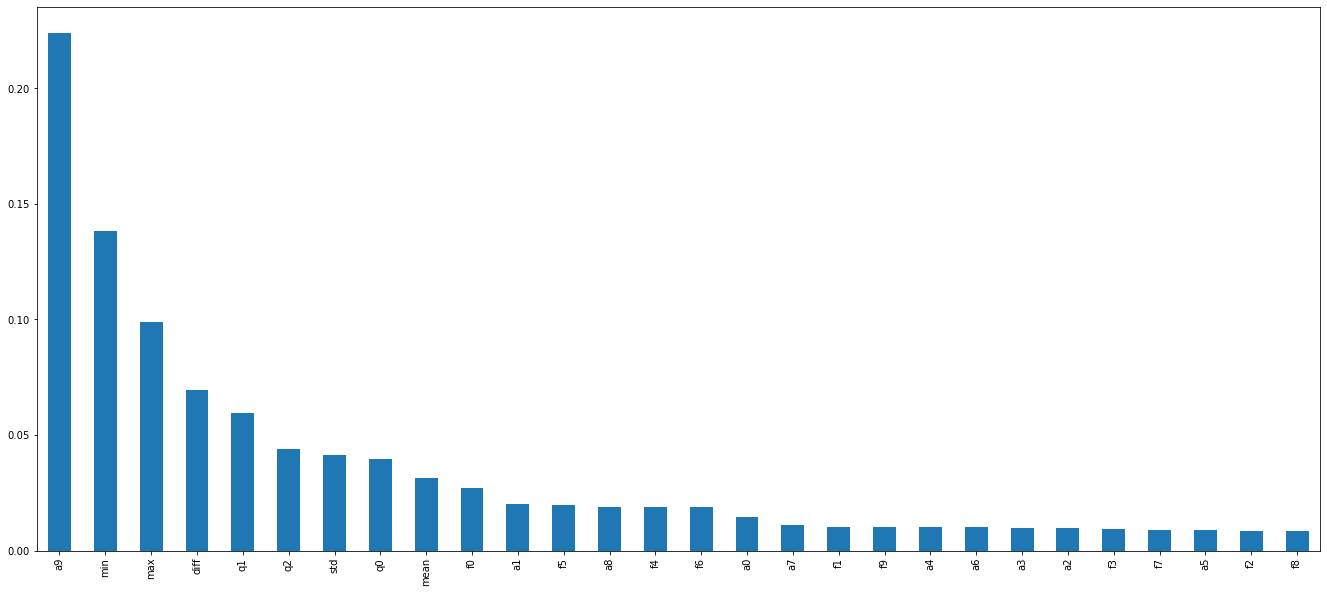

train on chunk is done..


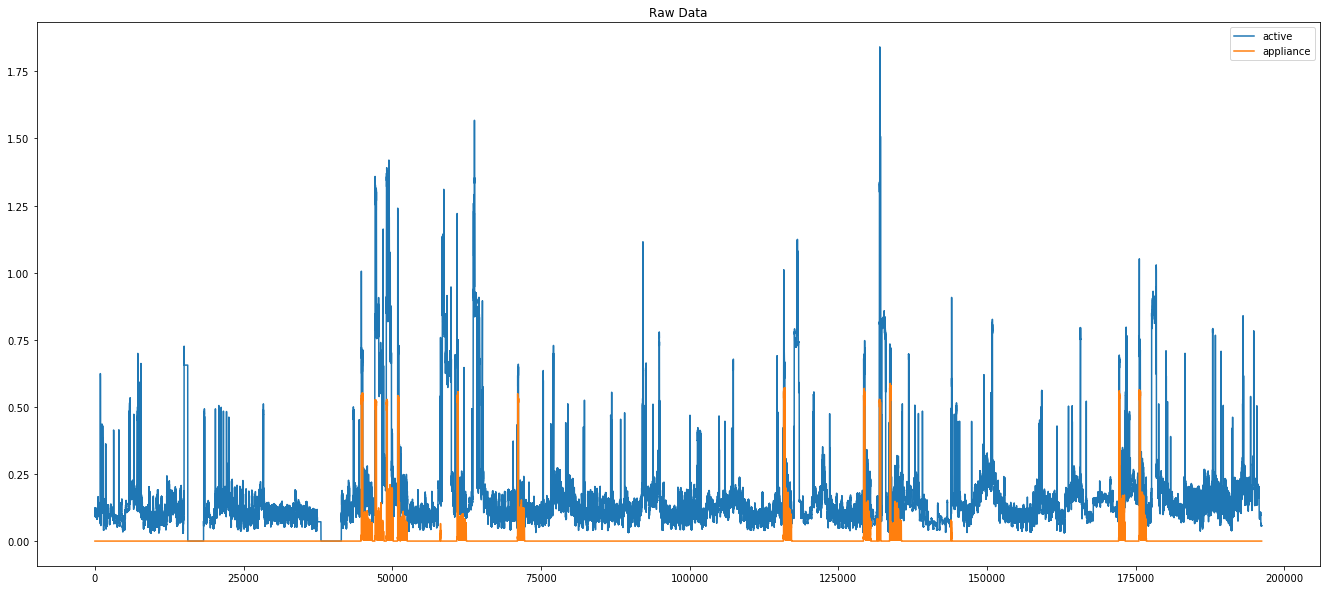

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.2min finished


model fit is done..
a9      0.216201
min     0.154356
max     0.099161
diff    0.070804
q1      0.061208
q2      0.042128
std     0.041423
q0      0.040415
mean    0.030057
f0      0.026193
f5      0.019245
a1      0.019104
a8      0.018140
f6      0.017824
f4      0.017821
a0      0.014369
a7      0.010778
f1      0.010005
f9      0.009897
a4      0.009815
a6      0.009795
a3      0.009433
a2      0.009358
f3      0.008811
f7      0.008750
a5      0.008532
f2      0.008350
f8      0.008026
dtype: float64


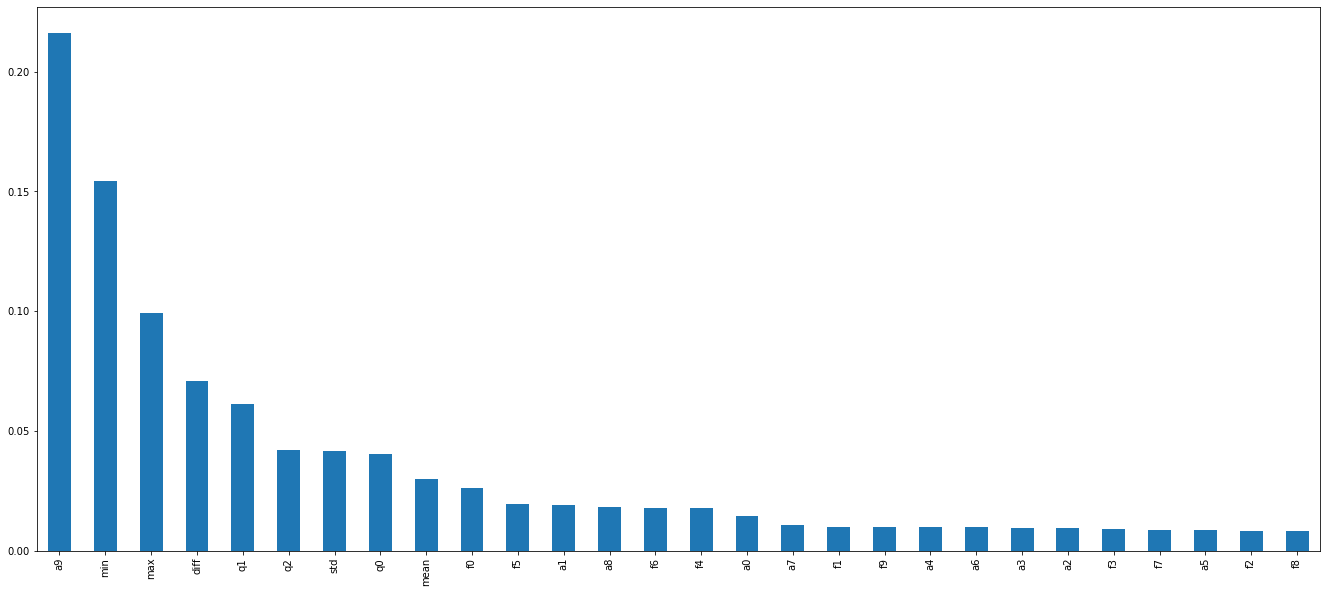

train on chunk is done..


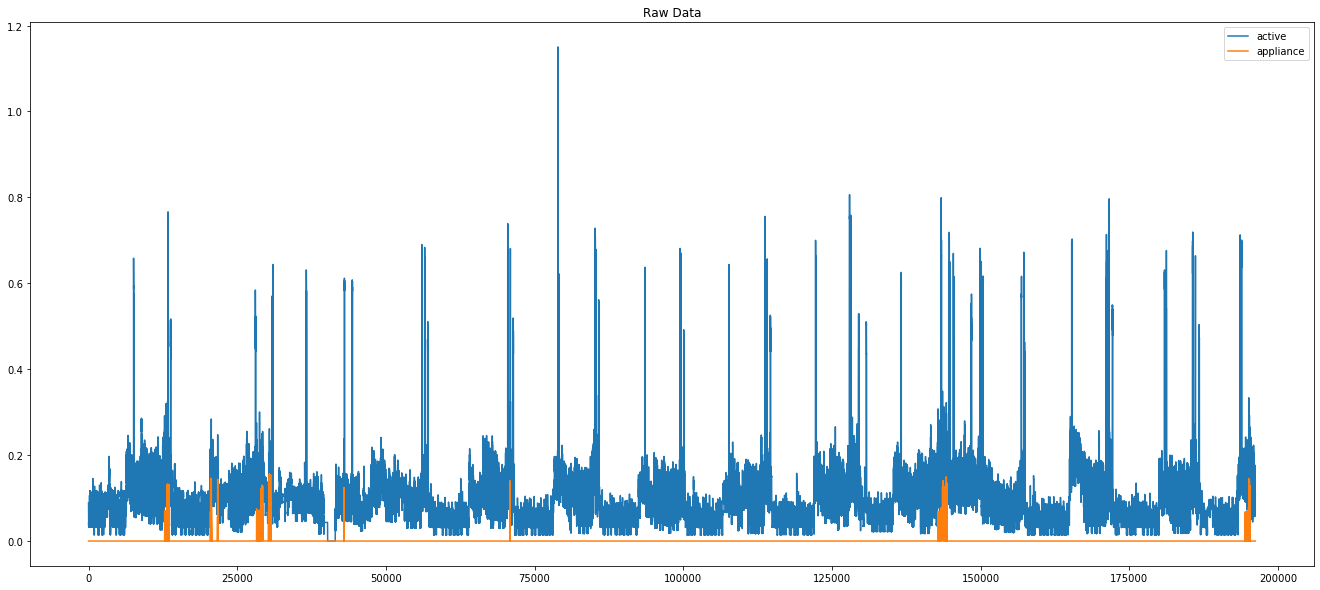

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.1min finished


model fit is done..
a9      0.207445
min     0.148166
max     0.109112
diff    0.072800
q1      0.059843
q2      0.041559
std     0.040963
q0      0.040172
mean    0.029028
f0      0.025362
f5      0.020035
a1      0.019032
a8      0.018542
f4      0.018088
f6      0.018026
a0      0.014794
a7      0.011357
a4      0.010407
a6      0.010345
f1      0.010227
a3      0.010080
f9      0.010077
a2      0.009883
f3      0.009257
f7      0.009161
a5      0.009082
f2      0.008714
f8      0.008442
dtype: float64


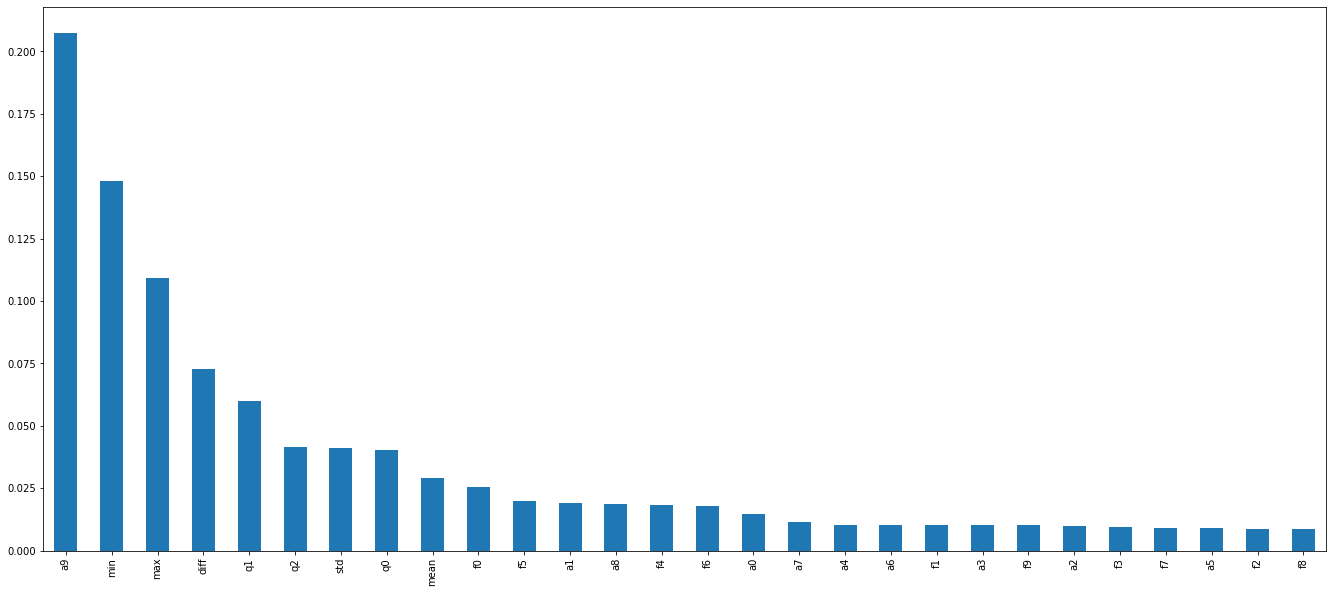

train on chunk is done..


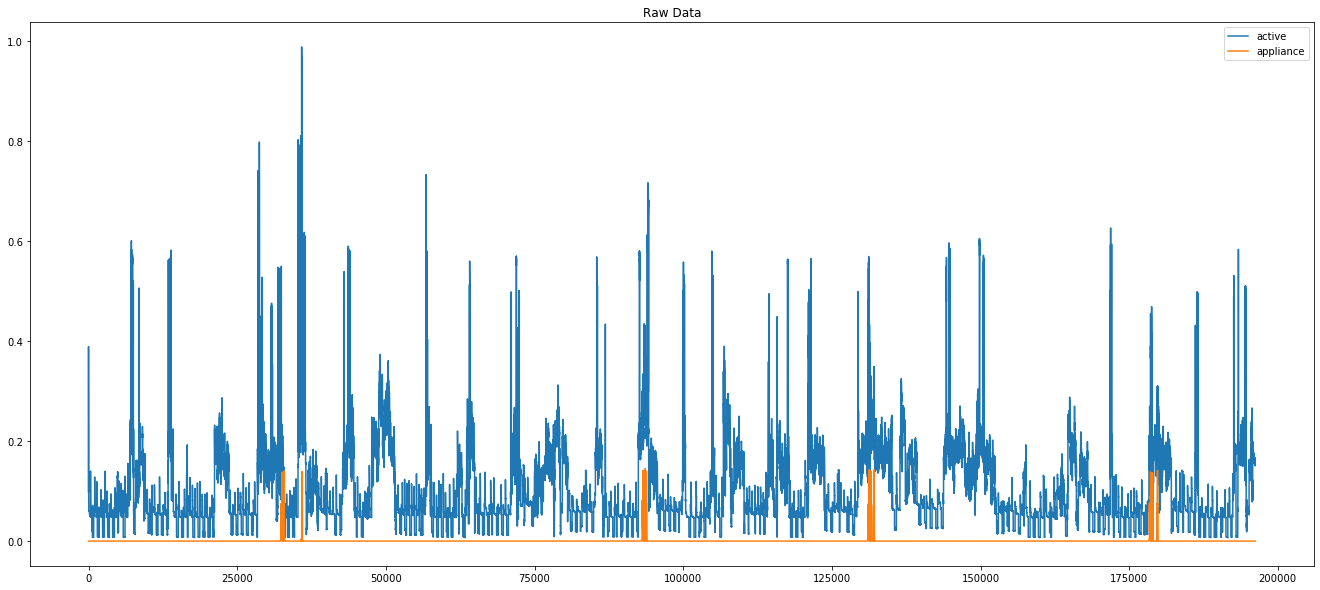

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.3min finished


model fit is done..
a9      0.200222
min     0.147848
max     0.109591
diff    0.074782
q1      0.058792
q0      0.042285
std     0.042187
q2      0.042158
mean    0.028122
f0      0.024657
f5      0.020730
a1      0.019183
a8      0.018741
f4      0.017947
f6      0.017941
a0      0.015209
a7      0.011586
a4      0.010536
a6      0.010506
f1      0.010424
f9      0.010240
a2      0.010235
a3      0.010200
f3      0.009655
f7      0.009486
a5      0.009187
f2      0.008910
f8      0.008641
dtype: float64


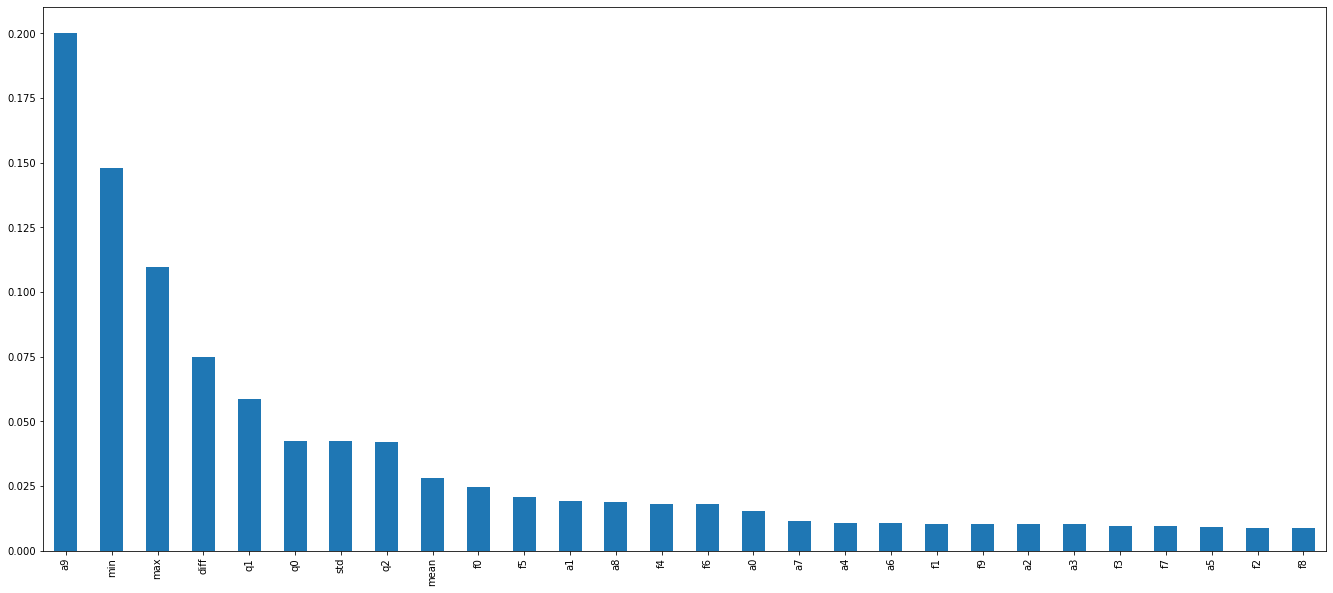

train on chunk is done..


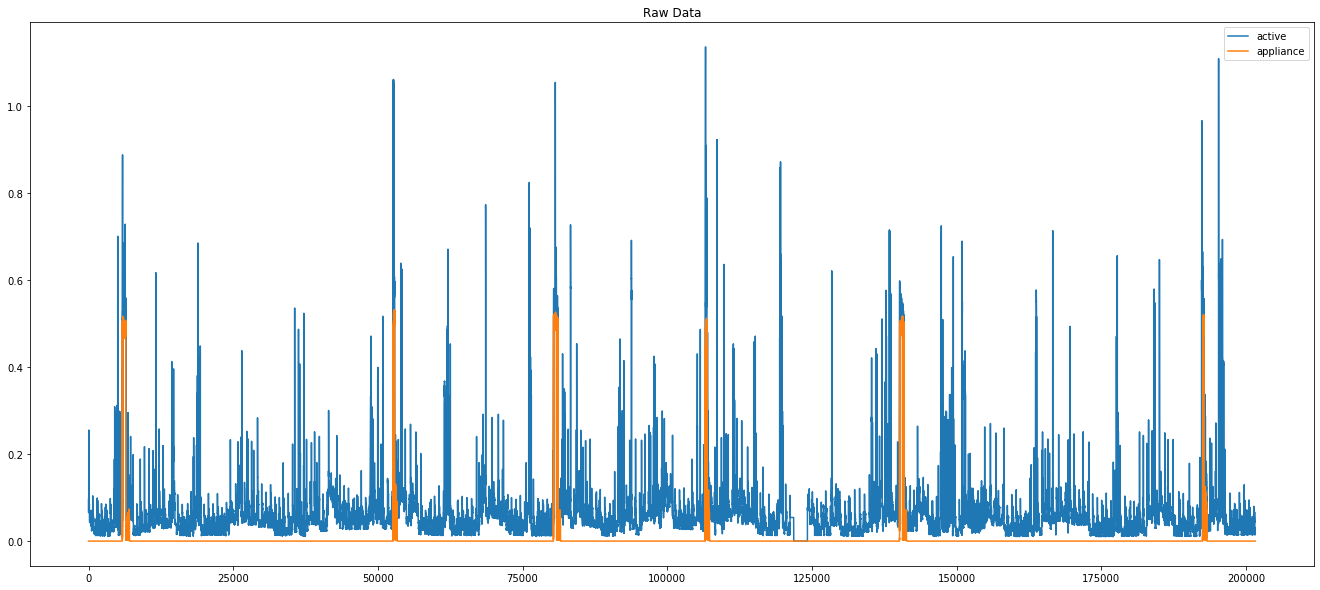

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.6min finished


model fit is done..
a9      0.191384
min     0.141687
max     0.105261
q0      0.077394
diff    0.072191
q1      0.056621
std     0.044456
q2      0.040381
mean    0.026782
f0      0.023535
f5      0.019873
a1      0.018360
a8      0.018035
f4      0.017146
f6      0.017123
a0      0.014825
a7      0.011120
f1      0.010129
a4      0.010079
a6      0.010056
f9      0.009945
a2      0.009824
a3      0.009777
f3      0.009278
f7      0.009119
a5      0.008807
f2      0.008537
f8      0.008277
dtype: float64


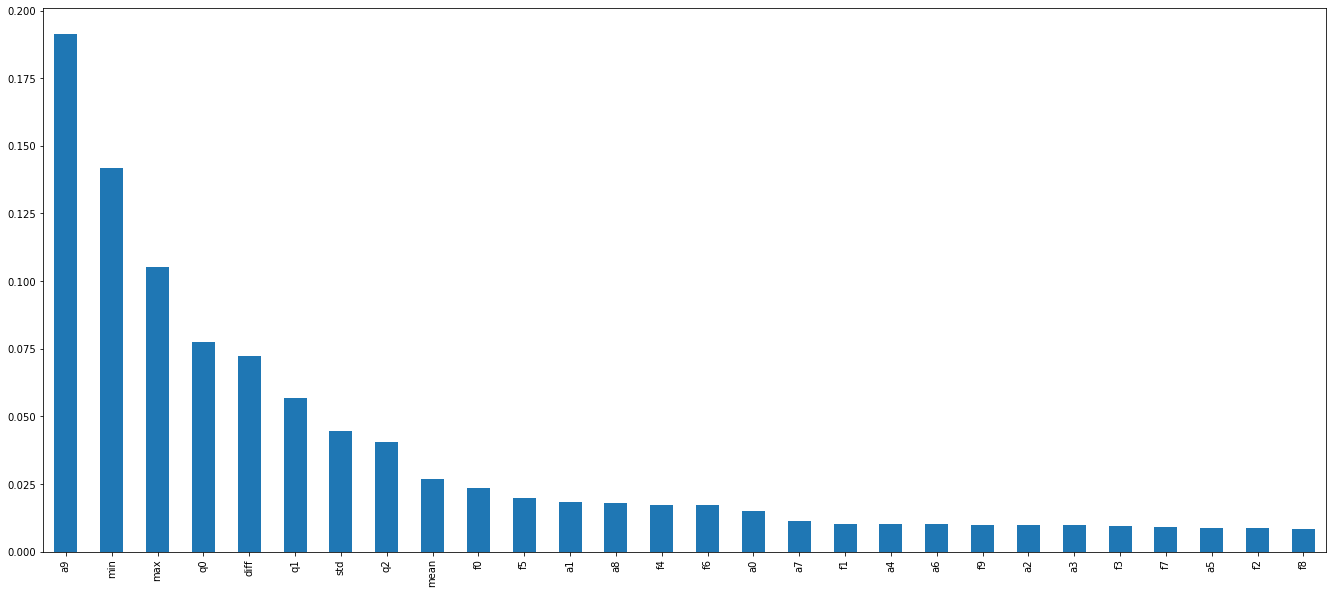

train on chunk is done..


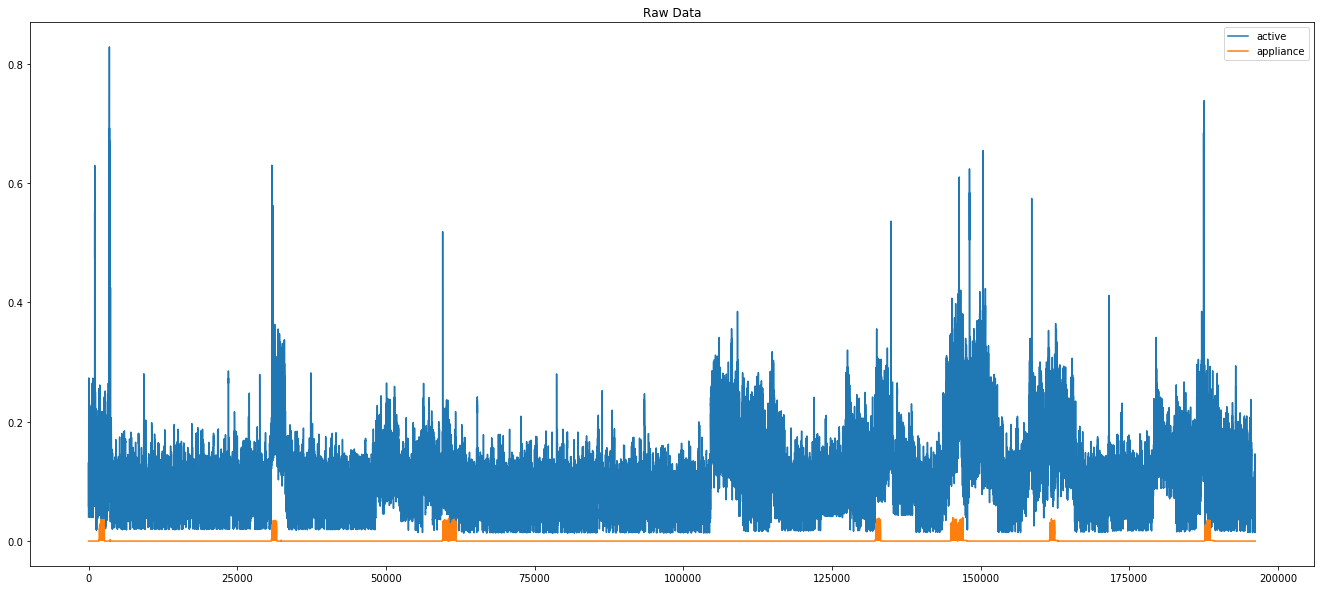

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.1min finished


model fit is done..
a9      0.183955
min     0.139291
max     0.108792
q0      0.075678
diff    0.071711
q1      0.055870
std     0.044365
q2      0.041159
mean    0.026174
f0      0.023058
f5      0.020656
a1      0.018847
a8      0.018473
f4      0.017196
f6      0.017133
a0      0.015433
a7      0.011808
a4      0.010833
a6      0.010803
a2      0.010633
a3      0.010537
f1      0.010503
f9      0.010298
f3      0.009774
f7      0.009628
a5      0.009443
f2      0.009109
f8      0.008840
dtype: float64


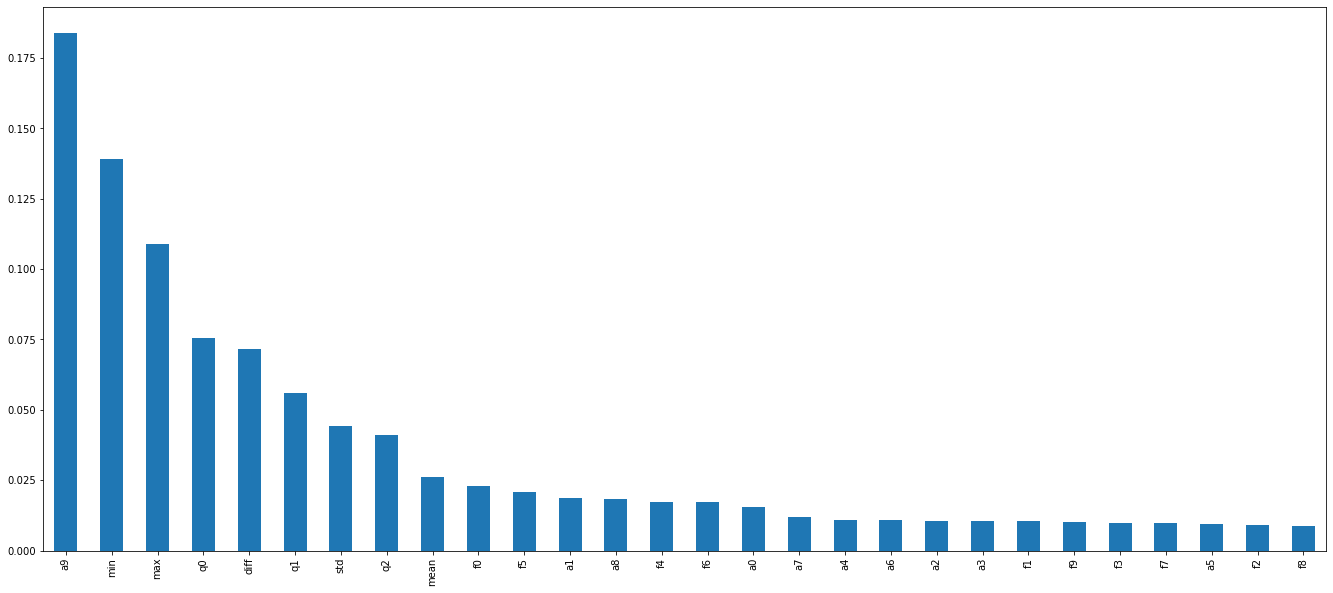

train on chunk is done..
elapsed time (secs) = 2095.9260165691376


In [360]:
#appliances = ['television', 'washing machine', 'water filter', 'microwave']
appliances = ['washing machine']

start = time.time()

dataset.set_window(start='2016-09-01 00:00:00', end='2016-09-15 00:00:00')
for home_id in [5,6,19]:     
    train_elec = dataset.buildings[home_id].elec
    train_mains = train_elec.all_meters()[0]
    
    for aname in appliances:
        try:
            train_meter = train_elec.submeters()[aname]

            model.add_trees()
            model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
        except Exception as e:
            continue
            
dataset.set_window(start='2016-10-01 00:00:00', end='2016-10-15 00:00:00')
for home_id in [3,7]:     
    train_elec = dataset.buildings[home_id].elec
    train_mains = train_elec.all_meters()[0]
    
    for aname in appliances:
        try:
            train_meter = train_elec.submeters()[aname]

            model.add_trees()
            model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
        except Exception as e:
            continue
            
dataset.set_window(start='2016-12-01 00:00:00', end='2016-12-15 00:00:00')
for home_id in [1,2,4,9,18,22]:     
    train_elec = dataset.buildings[home_id].elec
    train_mains = train_elec.all_meters()[0]
    
    for aname in appliances:
        try:
            train_meter = train_elec.submeters()[aname]

            model.add_trees()
            model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
        except Exception as e:
            continue
            
end = time.time()            
print("elapsed time (secs) = " + str(end-start))

New sensible chunk: 196200
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    1.4s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    2.5s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:    3.8s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:    5.5s
[Parallel(n_jobs=32)]: Done 2100 out of 2100 | elapsed:    6.5s finished


Disaggregation is done..
============ Relative error in total energy: 0.5726725044784492
============ Mean absolute error(in Watts): 21.180208093935473
============ Recall: 0.8566353440436496
============ Precision: 0.777059205244113
============ Accuracy: 0.8364220183486238
============ F1 Score: 0.8149092251263005
196200
196200
upper = 14.216228709568579
least_amount = 5.212423172573248
precision = 0.9753086419753086
# of peaks = 81
activations : [6000, 6600, 7200, 16200, 16800, 17400, 19800, 20400, 21000, 22200, 33600, 34200, 34800, 35400, 36000, 36600, 37200, 37800, 38400, 39000, 49200, 51000, 52200, 52800, 57600, 72000, 73800, 79200, 79800, 80400, 81000, 81600, 82200, 82800, 93600, 94200, 95400, 102000, 102600, 106800, 107400, 108000, 108600, 109200, 116400, 118800, 121200, 121800, 123000, 123600, 124200, 124800, 125400, 126000, 126600, 127200, 132000, 136200, 136800, 137400, 139200, 145200, 150600, 151200, 151800, 158400, 160800, 161400, 175800, 180000, 180600, 181200, 181800, 18

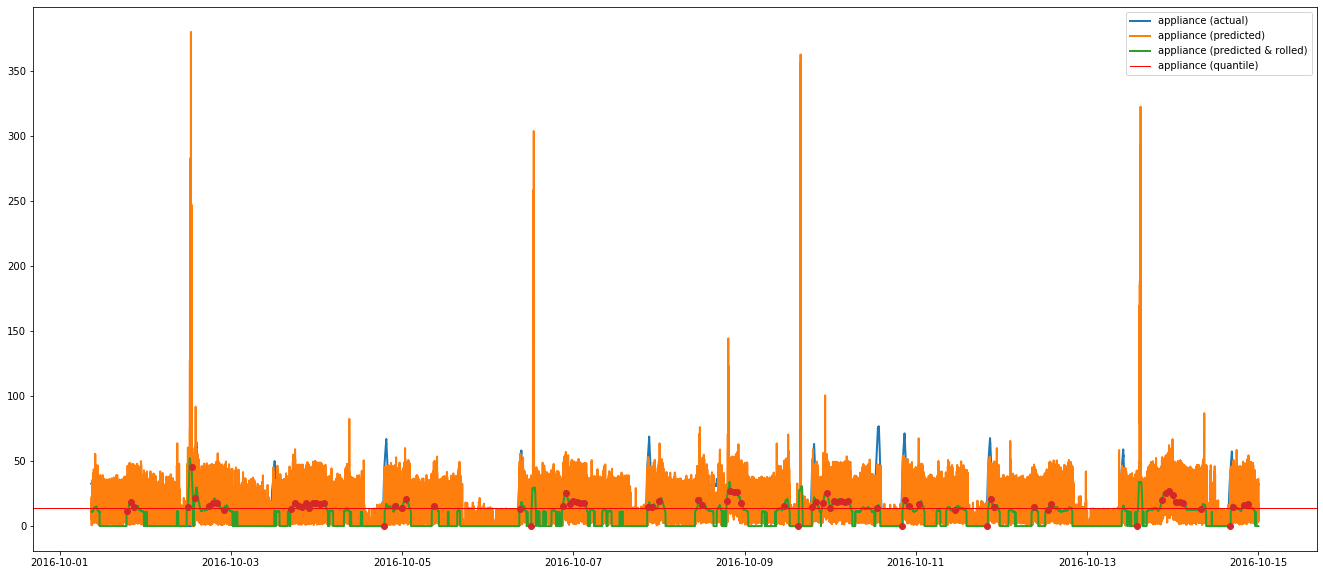

New sensible chunk: 201600
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    2.7s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:    4.5s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:    6.8s
[Parallel(n_jobs=32)]: Done 2100 out of 2100 | elapsed:    8.2s finished


Disaggregation is done..
============ Relative error in total energy: 0.34001259004793677
============ Mean absolute error(in Watts): 39.064167801352674
============ Recall: 0.747421553832544
============ Precision: 0.6032220672971929
============ Accuracy: 0.6453025793650794
============ F1 Score: 0.6676241871534218
201600
201600
upper = 21.469778967027864
least_amount = 28.83032265218099
precision = 0.8333333333333334
# of peaks = 84
activations : [4200, 4800, 5400, 6000, 11400, 12000, 12600, 13200, 16800, 21600, 24600, 25200, 34800, 35400, 37800, 40200, 41400, 49800, 50400, 52800, 54000, 54600, 62400, 64200, 64800, 68400, 69000, 70200, 70800, 77400, 78600, 79200, 80400, 81000, 82200, 85200, 91200, 93600, 97200, 97800, 98400, 109200, 109800, 110400, 113400, 123000, 123600, 124200, 124800, 125400, 138000, 139800, 140400, 142200, 142800, 150000, 150600, 151200, 154800, 155400, 156000, 157200, 165000, 165600, 168600, 169200, 169800, 170400, 171000, 178200, 178800, 179400, 180000, 183600

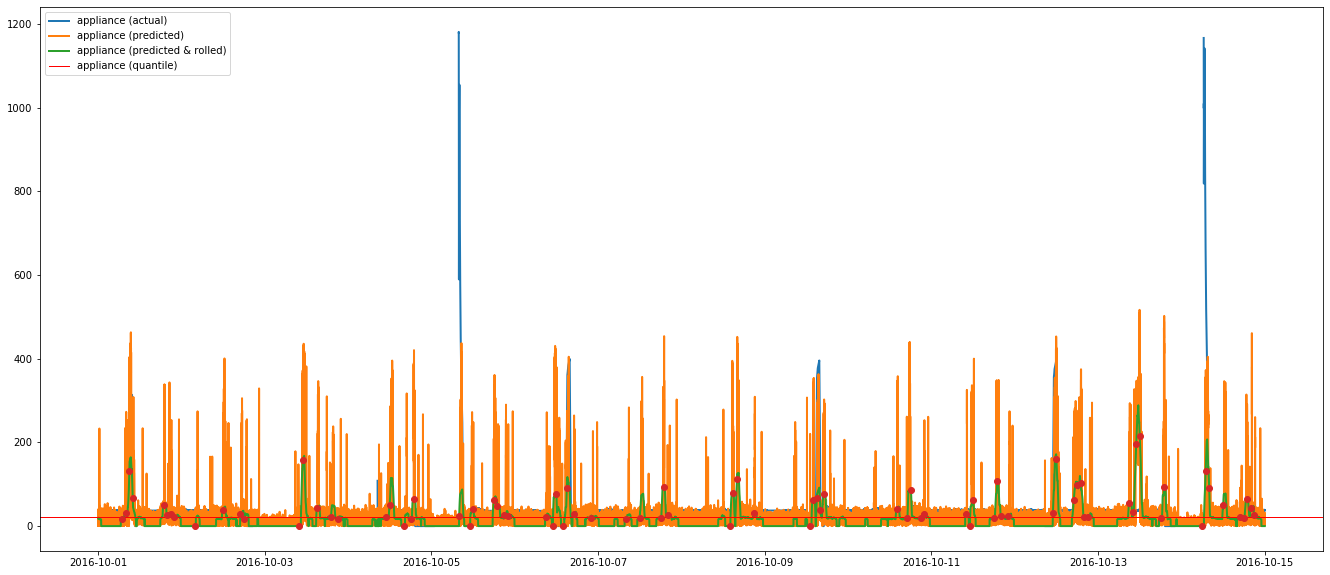

New sensible chunk: 196200
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    1.5s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    2.5s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:    3.6s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:    5.1s
[Parallel(n_jobs=32)]: Done 2100 out of 2100 | elapsed:    6.2s finished


Disaggregation is done..
============ Relative error in total energy: 0.7641420082362945
============ Mean absolute error(in Watts): 9.796303577684764
============ Recall: 0.4693295292439372
============ Precision: 0.02754751737419409
============ Accuracy: 0.7556371049949031
============ F1 Score: 0.05204049351471054
196200
196200
upper = 14.187061892139415
least_amount = 11.616299444595972
precision = 0.03614457831325301
# of peaks = 83
activations : [0, 600, 1200, 3600, 4200, 6600, 7200, 7800, 12600, 21000, 27600, 36000, 36600, 42600, 49800, 50400, 51000, 51600, 56400, 57000, 63600, 64200, 64800, 72000, 79800, 80400, 85800, 86400, 87000, 87600, 88200, 88800, 89400, 90600, 91200, 91800, 92400, 93000, 95400, 100800, 101400, 102000, 102600, 103200, 103800, 104400, 105000, 105600, 106200, 106800, 107400, 108600, 114000, 114600, 121200, 121800, 122400, 128400, 129000, 136200, 136800, 137400, 143400, 148800, 149400, 150000, 150600, 151200, 151800, 152400, 156600, 157200, 157800, 165000, 1

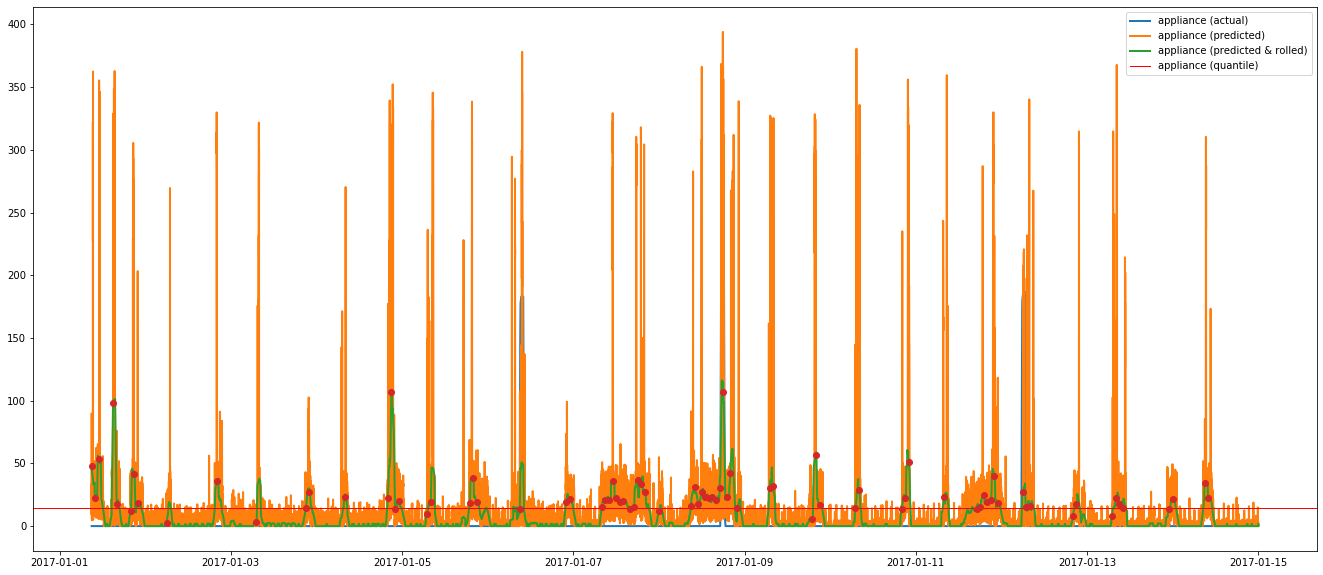

83

In [361]:
disaggregate(dataset, model, 3, 'rice cooker', '2016-10-01 00:00:00', '2016-10-15 00:00:00', True)
disaggregate(dataset, model, 6, 'rice cooker', '2016-10-01 00:00:00', '2016-10-15 00:00:00', True)
disaggregate(dataset, model, 9, 'rice cooker', '2017-01-01 00:00:00', '2017-01-15 00:00:00', True)

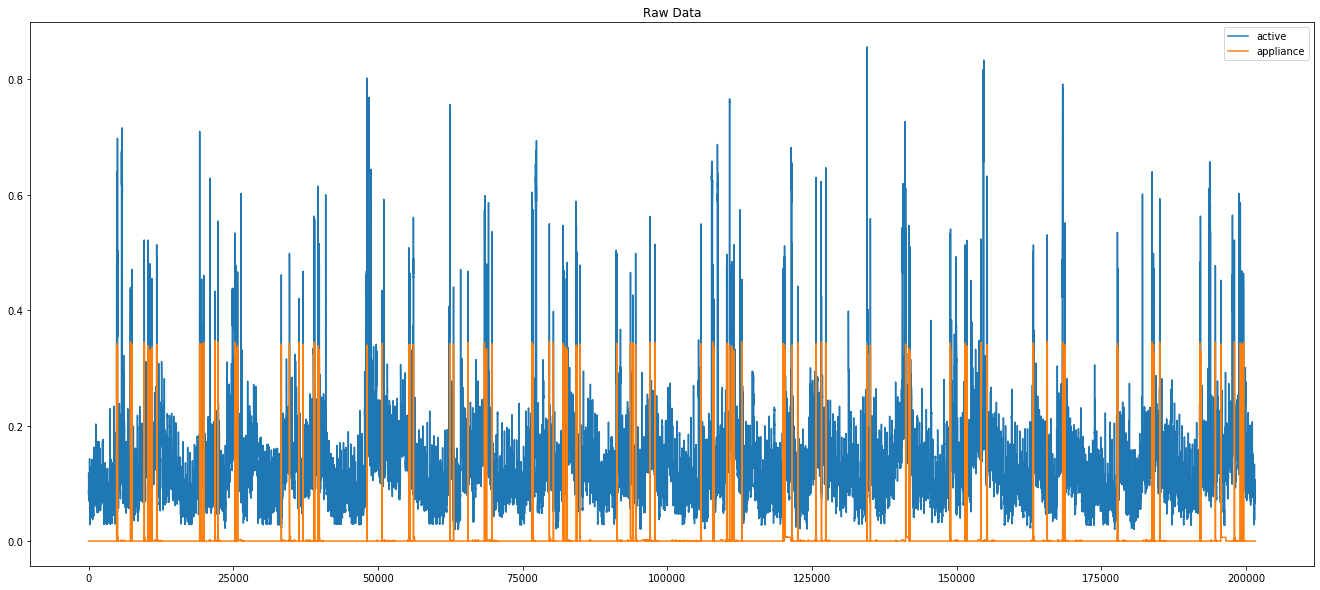

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.3min finished


model fit is done..
a9      0.185322
min     0.134973
max     0.106448
diff    0.079514
q0      0.072656
q1      0.053668
std     0.044222
q2      0.039851
mean    0.025142
f0      0.022141
f5      0.020894
f4      0.020792
f6      0.020385
a8      0.019785
a1      0.018734
a0      0.015616
a7      0.011554
a4      0.010585
a6      0.010524
a2      0.010419
a3      0.010343
f1      0.010309
f9      0.010103
f3      0.009613
f7      0.009470
a5      0.009234
f2      0.008973
f8      0.008730
dtype: float64


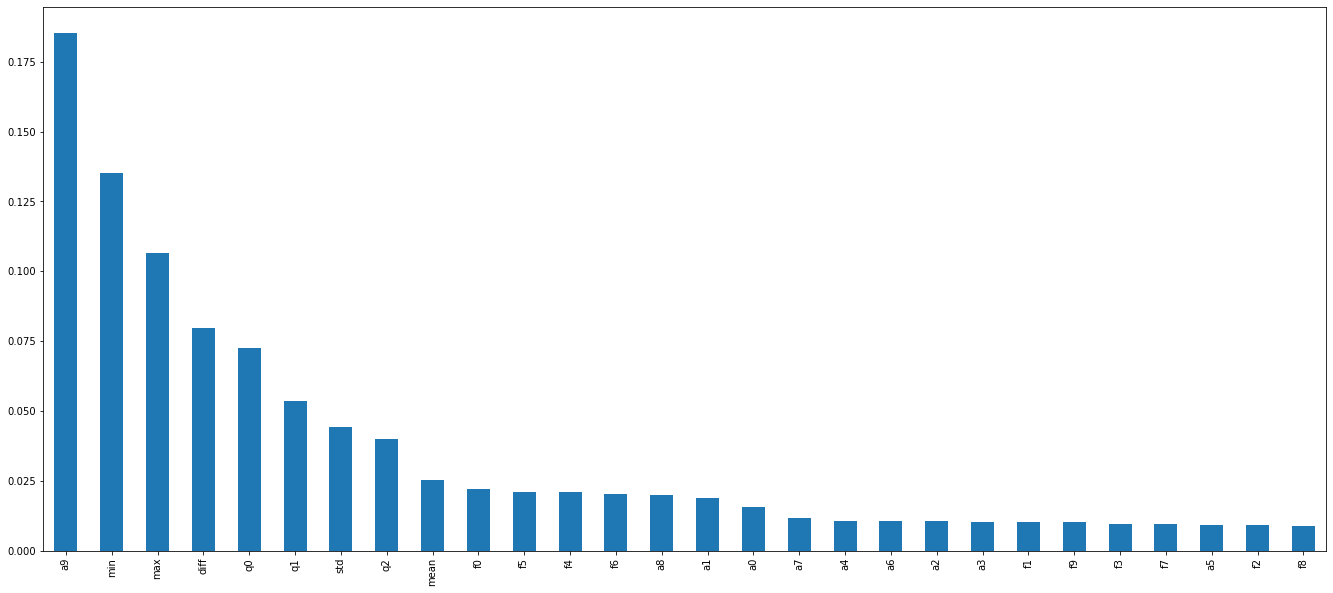

train on chunk is done..


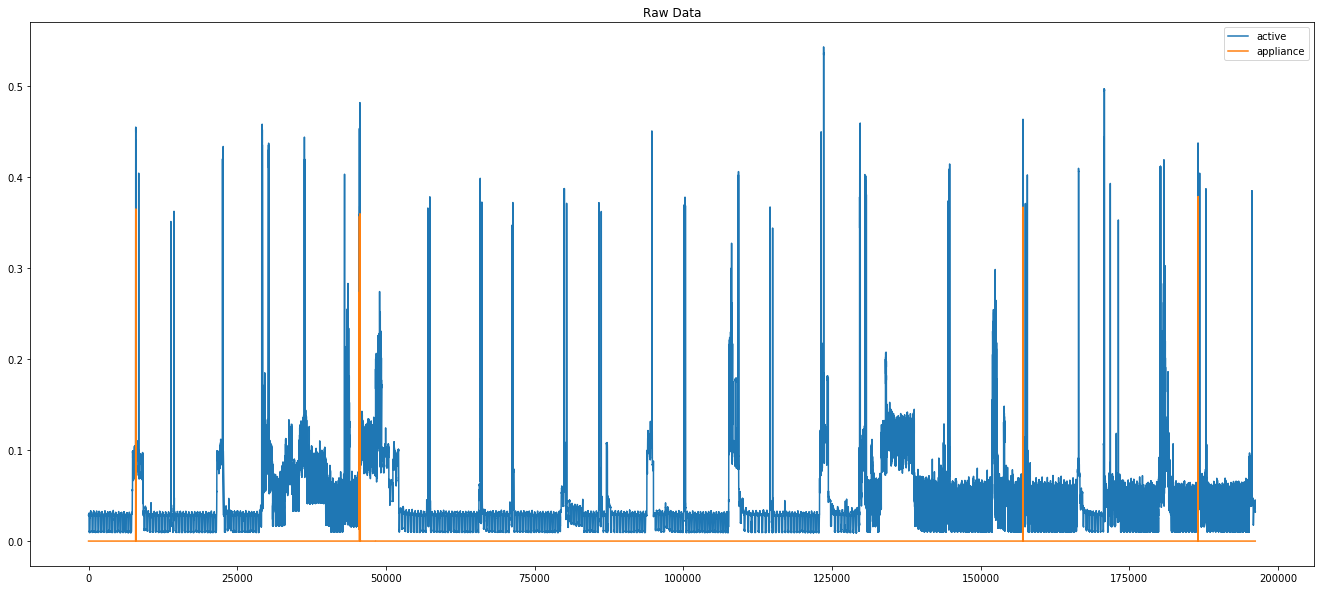

feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:  1.2min finished


model fit is done..
a9      0.188153
min     0.132952
max     0.104736
diff    0.085508
q0      0.070903
q1      0.053136
std     0.044662
q2      0.039361
mean    0.024584
f0      0.021748
f4      0.020625
f5      0.020343
f6      0.020306
a8      0.019654
a1      0.018408
a0      0.015194
a7      0.011428
a6      0.011040
a4      0.010483
a3      0.010406
a2      0.010335
f1      0.010242
f9      0.010052
f3      0.009369
f7      0.009276
a5      0.009159
f2      0.009120
f8      0.008816
dtype: float64


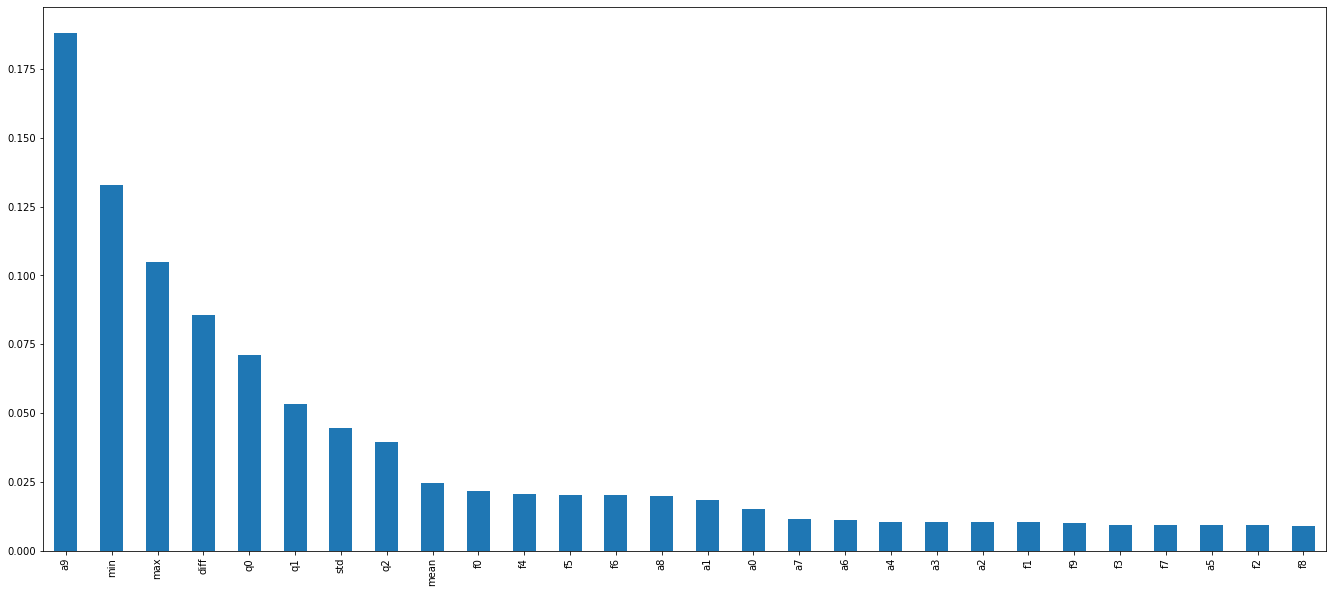

train on chunk is done..
elapsed time (secs) = 394.28938269615173


In [362]:
#appliances = ['television', 'washing machine', 'water filter', 'microwave']
appliances = ['microwave']

start = time.time()

dataset.set_window(start='2016-12-01 00:00:00', end='2016-12-15 00:00:00')
for home_id in [1,10]:     
    train_elec = dataset.buildings[home_id].elec
    train_mains = train_elec.all_meters()[0]
    
    for aname in appliances:
        try:
            train_meter = train_elec.submeters()[aname]

            model.add_trees()
            model.train(train_mains, train_meter, epochs=EPOCHS, sample_period=TRAIN_SAMPLE_PERIOD)
        except Exception as e:
            continue
            
end = time.time()            
print("elapsed time (secs) = " + str(end-start))

New sensible chunk: 196200
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    1.0s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    1.9s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:    2.9s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:    4.6s
[Parallel(n_jobs=32)]: Done 2300 out of 2300 | elapsed:    6.0s finished


Disaggregation is done..
============ Relative error in total energy: 0.6024015757466988
============ Mean absolute error(in Watts): 21.443917910214918
============ Recall: 0.8125613822370416
============ Precision: 0.7928166664694957
============ Accuracy: 0.8319469928644241
============ F1 Score: 0.8025676031711815
196200
196200
upper = 13.09776715748012
least_amount = 5.866376683294773
precision = 0.975
# of peaks = 80
activations : [6000, 6600, 7200, 16200, 16800, 17400, 19800, 20400, 21000, 22200, 33600, 34200, 34800, 35400, 36000, 36600, 37200, 37800, 38400, 39000, 49200, 51000, 52200, 52800, 57600, 72000, 73800, 79200, 79800, 80400, 81000, 81600, 82200, 82800, 93600, 94200, 95400, 102000, 102600, 106800, 107400, 108000, 108600, 109200, 116400, 118800, 121200, 121800, 123000, 123600, 124200, 124800, 125400, 126000, 126600, 127200, 132000, 136200, 136800, 137400, 139200, 145200, 150600, 151200, 151800, 158400, 160800, 161400, 175800, 180000, 180600, 181200, 181800, 182400, 183000,

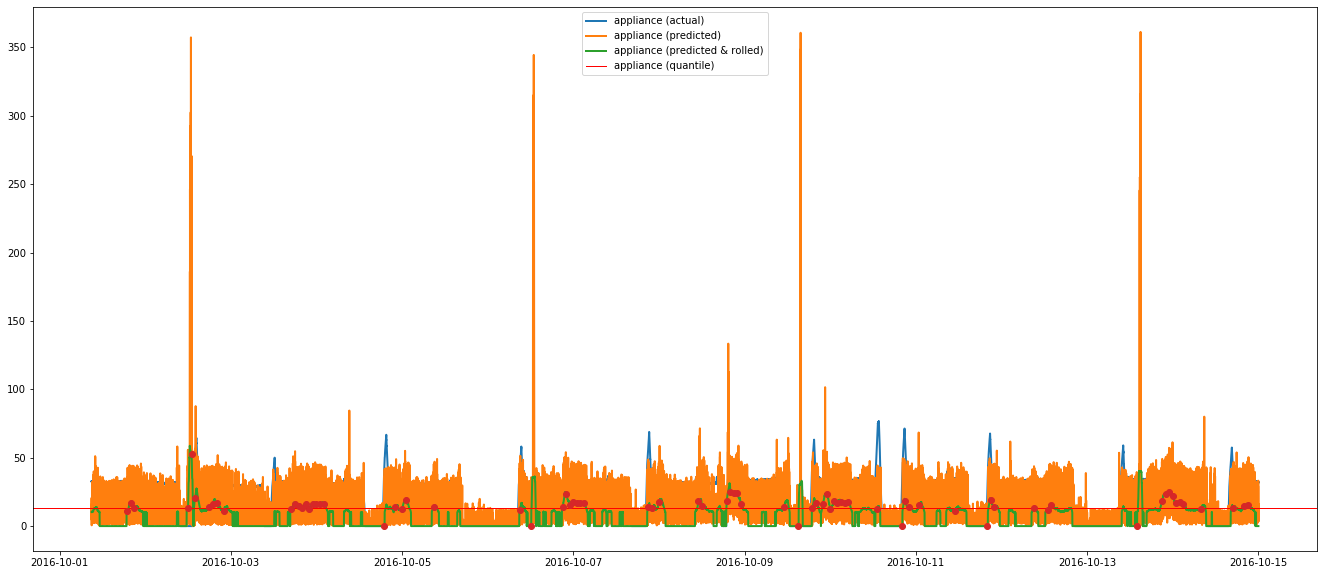

New sensible chunk: 201600
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.9s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    1.8s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    3.4s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:    5.5s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:    8.1s
[Parallel(n_jobs=32)]: Done 2300 out of 2300 | elapsed:   10.1s finished


Disaggregation is done..
============ Relative error in total energy: 0.3608444552618304
============ Mean absolute error(in Watts): 39.19842396879065
============ Recall: 0.7314877452255815
============ Precision: 0.6146856388235397
============ Accuracy: 0.6534821428571429
============ F1 Score: 0.6680194650901969
201600
201600
upper = 20.325871789852776
least_amount = 29.44554502360026
precision = 0.8674698795180723
# of peaks = 83
activations : [4200, 4800, 5400, 6000, 11400, 12000, 12600, 13800, 16800, 21600, 24600, 25200, 34800, 35400, 37800, 40200, 41400, 50400, 52800, 54000, 54600, 62400, 64200, 64800, 68400, 69000, 70200, 70800, 77400, 78600, 79200, 80400, 81000, 82200, 85200, 91200, 93600, 97200, 97800, 98400, 109200, 109800, 110400, 113400, 123000, 123600, 124200, 124800, 125400, 126000, 138000, 139800, 140400, 142200, 142800, 150000, 150600, 151200, 154800, 155400, 156000, 157200, 165000, 165600, 168600, 169200, 169800, 170400, 171000, 178200, 178800, 179400, 180000, 183600

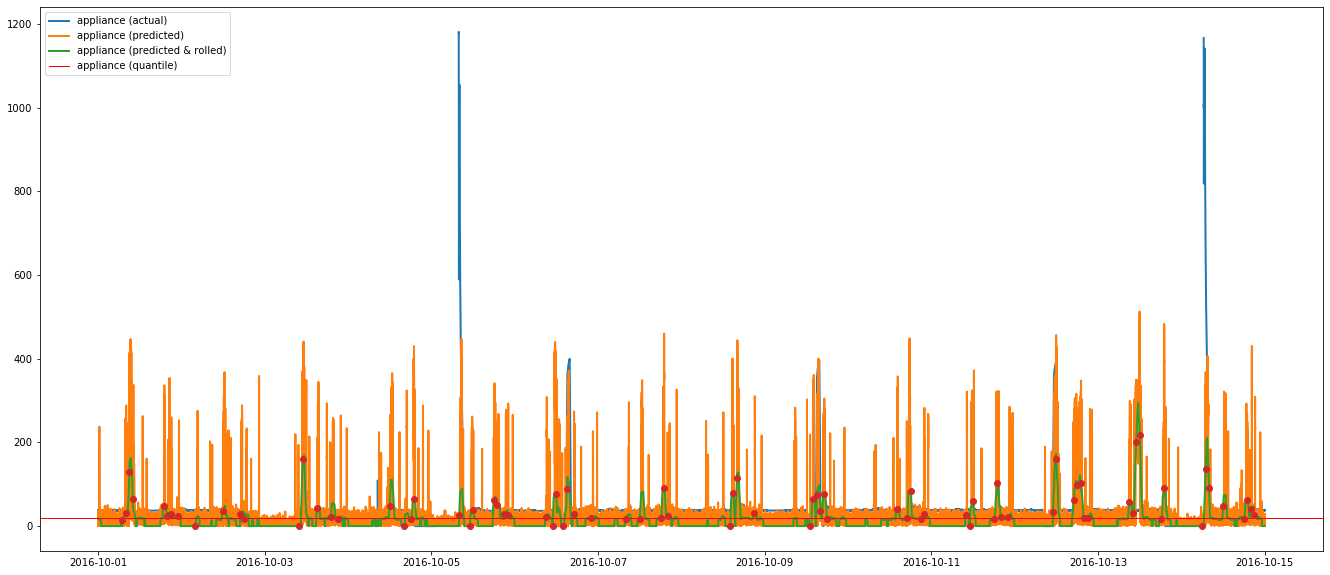

New sensible chunk: 196200
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    1.2s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    2.0s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:    2.9s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:    4.4s
[Parallel(n_jobs=32)]: Done 2300 out of 2300 | elapsed:    5.9s finished


Disaggregation is done..
============ Relative error in total energy: 0.757725314872812
============ Mean absolute error(in Watts): 9.559116010438279
============ Recall: 0.460413694721826
============ Precision: 0.02811349927048627
============ Accuracy: 0.7648165137614679
============ F1 Score: 0.052991277578245254
196200
196200
upper = 13.731957106764117
least_amount = 12.1569468181928
precision = 0.03614457831325301
# of peaks = 83
activations : [0, 600, 1200, 3600, 4200, 6600, 7200, 7800, 12600, 21000, 27600, 36000, 36600, 42000, 42600, 49800, 50400, 51600, 56400, 57000, 63600, 64200, 64800, 70800, 72000, 79800, 80400, 85800, 86400, 87000, 87600, 88200, 88800, 89400, 91200, 91800, 92400, 93000, 100800, 101400, 102000, 102600, 103200, 103800, 104400, 105000, 105600, 106200, 106800, 107400, 108600, 114000, 114600, 121200, 121800, 122400, 128400, 129000, 136200, 136800, 137400, 142800, 143400, 148800, 149400, 150000, 150600, 151200, 151800, 152400, 156600, 157200, 157800, 165000, 165

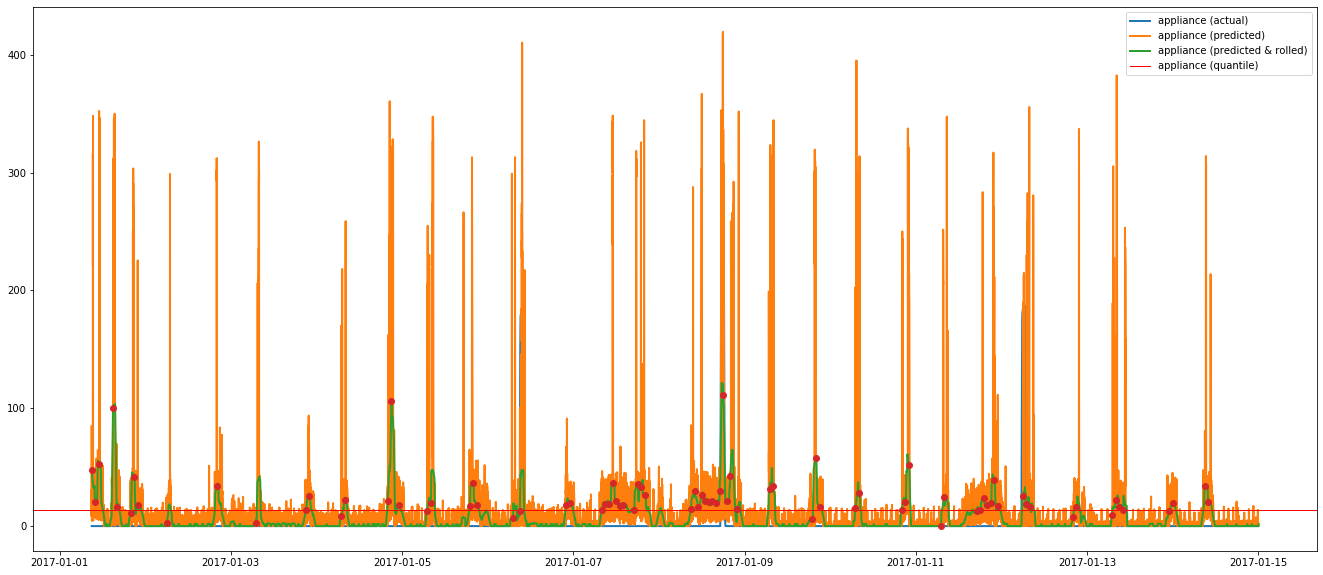

83

In [363]:
disaggregate(dataset, model, 3, 'rice cooker', '2016-10-01 00:00:00', '2016-10-15 00:00:00', True)
disaggregate(dataset, model, 6, 'rice cooker', '2016-10-01 00:00:00', '2016-10-15 00:00:00', True)
disaggregate(dataset, model, 9, 'rice cooker', '2017-01-01 00:00:00', '2017-01-15 00:00:00', True)

### Result Processing

New sensible chunk: 196200
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    1.1s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    1.9s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:    2.9s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:    4.6s
[Parallel(n_jobs=32)]: Done 2300 out of 2300 | elapsed:    6.0s finished


Disaggregation is done..
============ Relative error in total energy: 0.6024015757466988
============ Mean absolute error(in Watts): 21.443917910214918
============ Recall: 0.8125613822370416
============ Precision: 0.7928166664694957
============ Accuracy: 0.8319469928644241
============ F1 Score: 0.8025676031711815
196200
196200
least_amount = 177.5738444444445
upper = 17.510903205871582
2016-10-02 12:00:00+09:00
count1 = 429
count2 = 600
2016-10-02 13:00:00+09:00
count1 = 171
count2 = 600
2016-10-06 12:00:00+09:00
count1 = 327
count2 = 600
2016-10-06 13:00:00+09:00
count1 = 182
count2 = 600
2016-10-09 15:00:00+09:00
count1 = 425
count2 = 600
2016-10-13 14:00:00+09:00
count1 = 315
count2 = 600
2016-10-13 15:00:00+09:00
count1 = 169
count2 = 600
recall = 0.021406727828746176
precision = 1.0
accuracy = 0.021406727828746176
f1 = 0.041916167664670656
# of peaks = 7
activations : [16500, 17100, 74100, 74700, 119100, 176100, 176700]


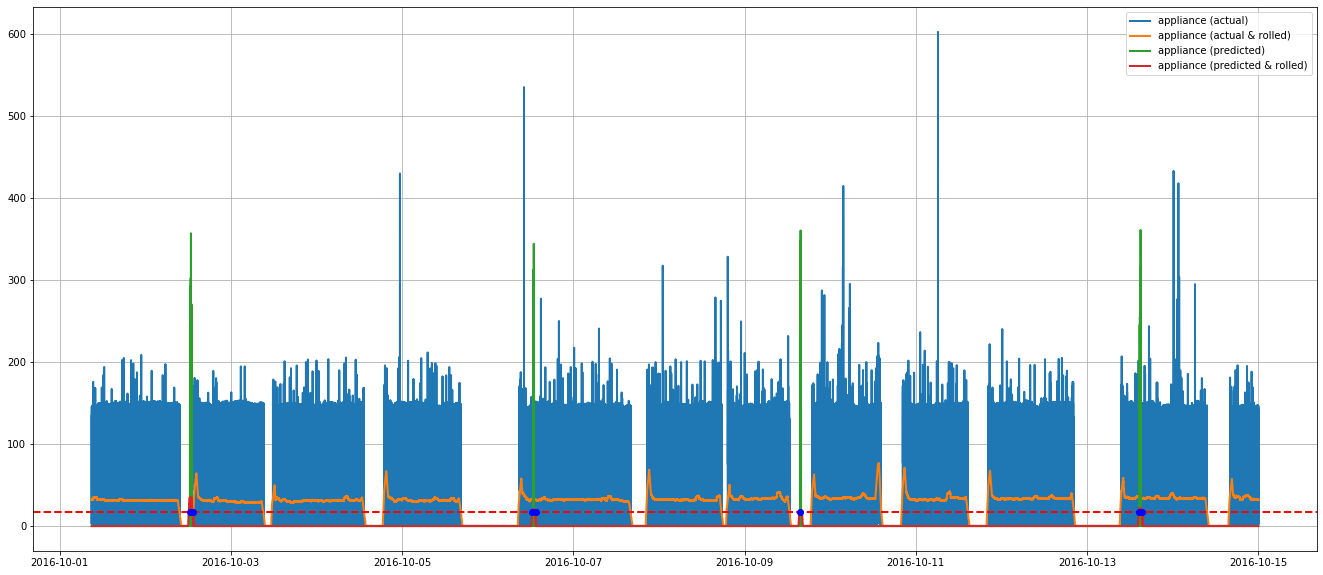

New sensible chunk: 201600
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.9s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    1.7s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    3.1s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:    5.1s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:    7.7s
[Parallel(n_jobs=32)]: Done 2300 out of 2300 | elapsed:    9.8s finished


Disaggregation is done..
============ Relative error in total energy: 0.3608444552618304
============ Mean absolute error(in Watts): 39.19842396879065
============ Recall: 0.7314877452255815
============ Precision: 0.6146856388235397
============ Accuracy: 0.6534821428571429
============ F1 Score: 0.6680194650901969
201600
201600
least_amount = 177.5738444444445
upper = 144.4235291671753
2016-10-03 11:00:00+09:00
count1 = 230
count2 = 0
2016-10-12 11:00:00+09:00
count1 = 255
count2 = 600
2016-10-13 11:00:00+09:00
count1 = 600
count2 = 600
2016-10-14 07:00:00+09:00
count1 = 354
count2 = 600
recall = 0.01048951048951049
precision = 0.75
accuracy = 0.15476190476190477
f1 = 0.020689655172413793
# of peaks = 4
activations : [35700, 165300, 179700, 191700]


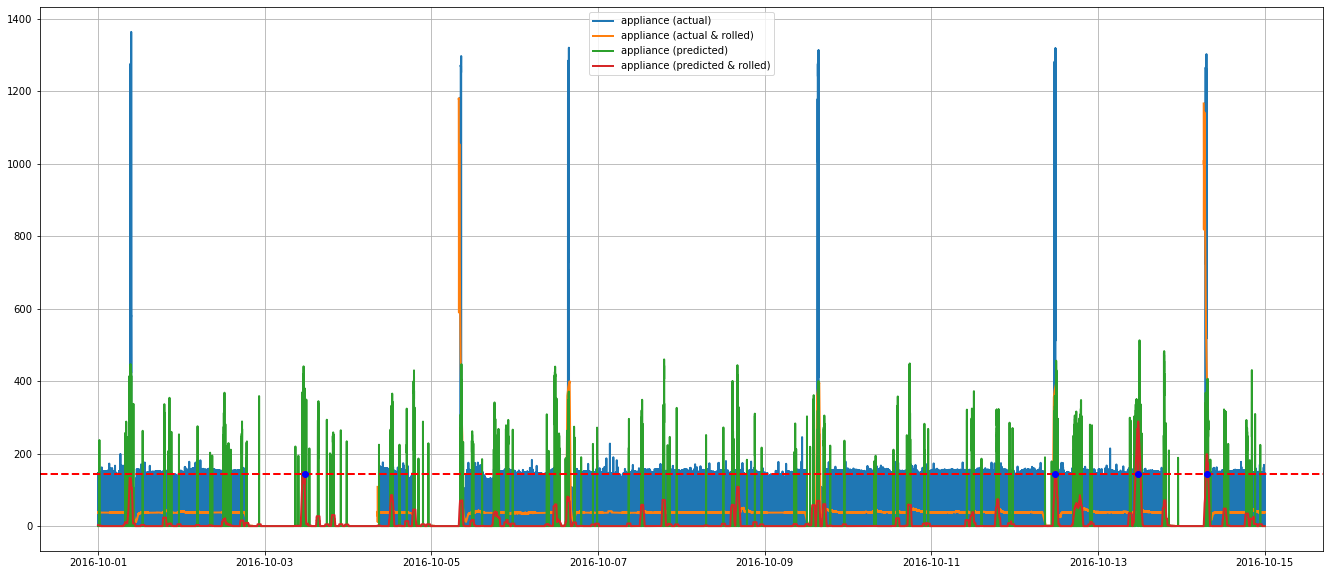

New sensible chunk: 196200
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.6s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    1.2s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    2.0s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:    3.0s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:    4.7s
[Parallel(n_jobs=32)]: Done 2300 out of 2300 | elapsed:    6.2s finished


Disaggregation is done..
============ Relative error in total energy: 0.757725314872812
============ Mean absolute error(in Watts): 9.559116010438279
============ Recall: 0.460413694721826
============ Precision: 0.02811349927048627
============ Accuracy: 0.7648165137614679
============ F1 Score: 0.052991277578245254
196200
196200
least_amount = 177.5738444444445
upper = 49.54649964650472
2017-01-01 15:00:00+09:00
count1 = 445
count2 = 600
2017-01-04 21:00:00+09:00
count1 = 462
count2 = 600
2017-01-08 17:00:00+09:00
count1 = 409
count2 = 600
2017-01-08 18:00:00+09:00
count1 = 191
count2 = 600
recall = 0.012232415902140673
precision = 1.0
accuracy = 0.012232415902140673
f1 = 0.02416918429003021
# of peaks = 4
activations : [3900, 50700, 105900, 106500]


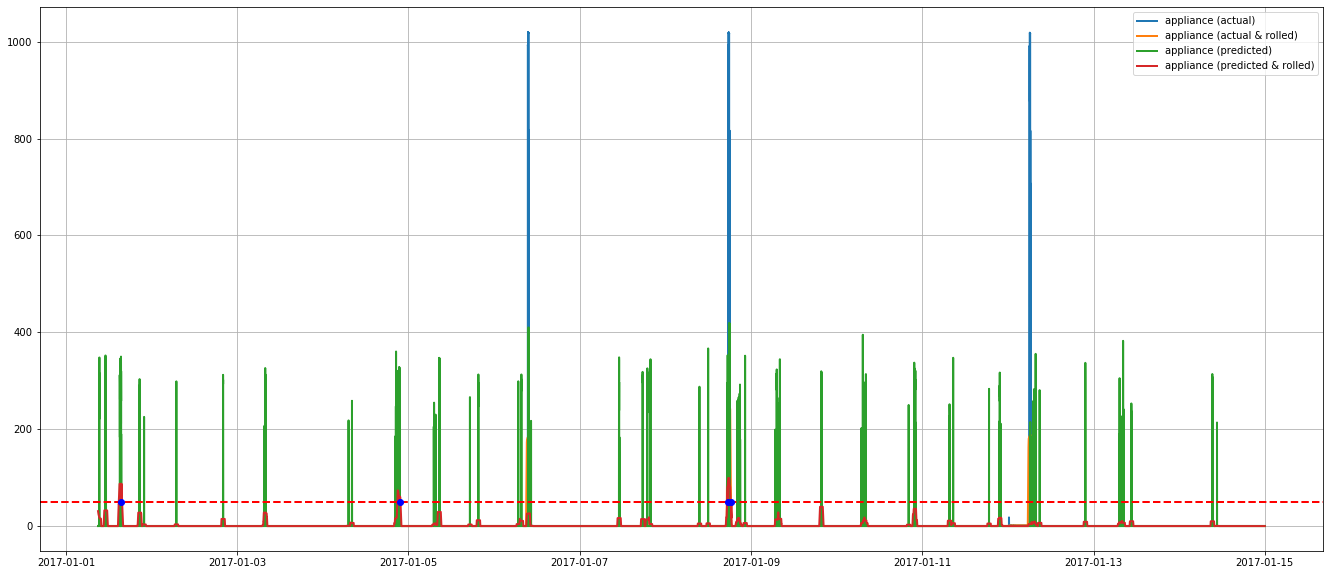

4

In [574]:
disaggregate(dataset, model, 3, 'rice cooker', '2016-10-01 00:00:00', '2016-10-15 00:00:00', True)
disaggregate(dataset, model, 6, 'rice cooker', '2016-10-01 00:00:00', '2016-10-15 00:00:00', True)
disaggregate(dataset, model, 9, 'rice cooker', '2017-01-01 00:00:00', '2017-01-15 00:00:00', True)

New sensible chunk: 14400
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    0.4s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:    1.0s
[Parallel(n_jobs=32)]: Done 2300 out of 2300 | elapsed:    1.3s finished


Disaggregation is done..
============ Relative error in total energy: 0.4679336275388144
============ Mean absolute error(in Watts): 23.001282645388137
============ Recall: 0.8185840707964602
============ Precision: 0.047625176985455014
============ Accuracy: 0.4804861111111111
============ F1 Score: 0.0900133803673519
14400
14400
least_amount = 177.5738444444445
upper = 49.54649964650472
2017-01-08 17:00:00+09:00
count1 = 409
count2 = 600
2017-01-08 18:00:00+09:00
count1 = 191
count2 = 600
recall = 0.08333333333333333
precision = 1.0
accuracy = 0.08333333333333333
f1 = 0.15384615384615385
# of peaks = 2
activations : [10500, 11100]


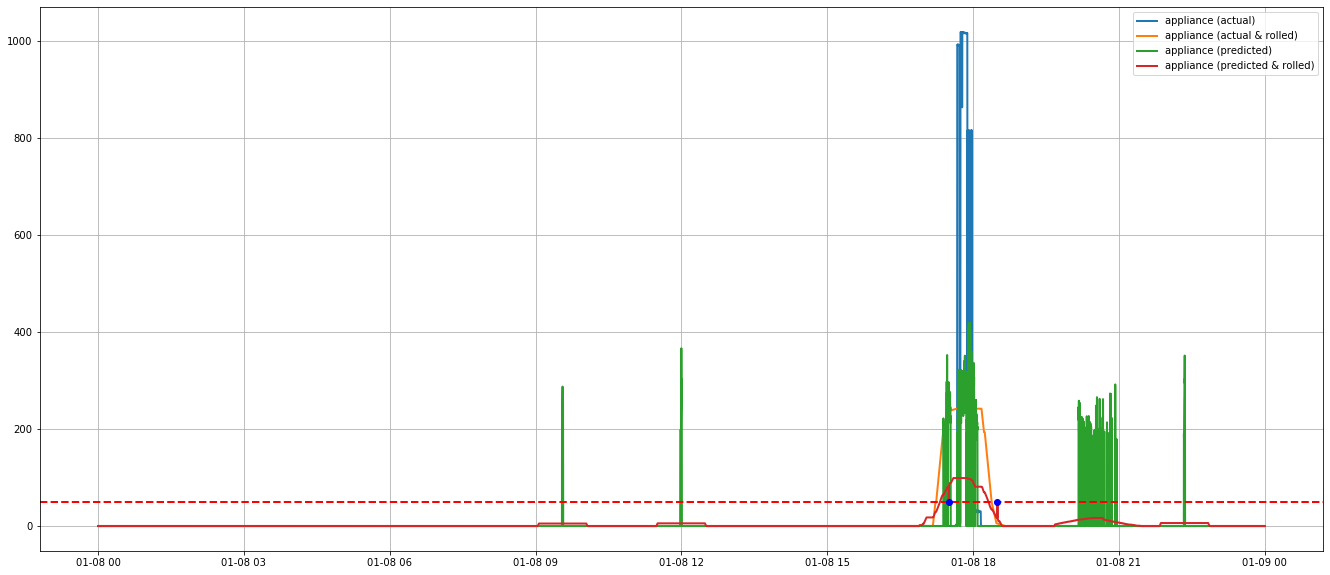

2

In [572]:
disaggregate(dataset, model, 9, 'rice cooker', '2017-01-08 00:00:00', '2017-01-09 00:00:00', True)

New sensible chunk: 3600
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:    1.1s
[Parallel(n_jobs=32)]: Done 2300 out of 2300 | elapsed:    1.4s finished


Disaggregation is done..
============ Relative error in total energy: 0.9364824585192664
============ Mean absolute error(in Watts): 3.58883510497852
============ Recall: 0.3
============ Precision: 0.02862595419847328
============ Accuracy: 0.8488888888888889
============ F1 Score: 0.05226480836236933
3600
3600
least_amount = 177.5738444444445
upper = 0.0
recall = 0.0
precision = 0.0
accuracy = 0.0
f1 = 0.0
# of peaks = 0
activations : []


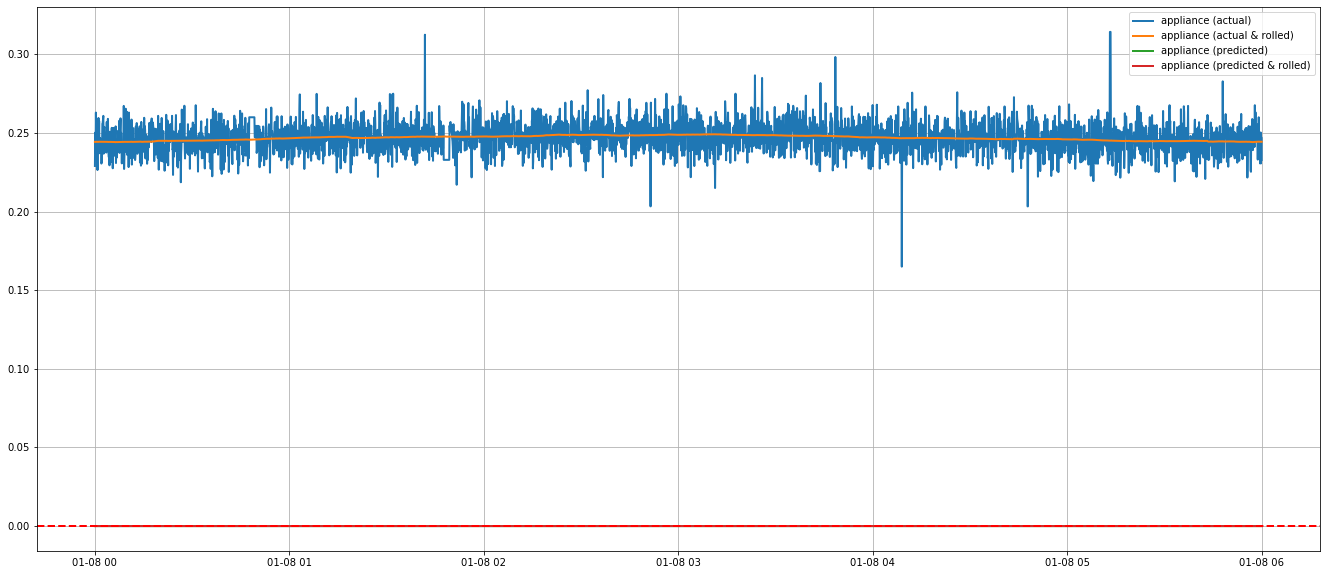

New sensible chunk: 3600
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:    1.1s
[Parallel(n_jobs=32)]: Done 2300 out of 2300 | elapsed:    1.4s finished


Disaggregation is done..
============ Relative error in total energy: 0.9812218197327418
============ Mean absolute error(in Watts): 12.686014671980432
============ Recall: 0.6739130434782609
============ Precision: 0.0184194890077243
============ Accuracy: 0.5369444444444444
============ F1 Score: 0.035858877964141125
3600
3600
least_amount = 177.5738444444445
upper = 3.515725702938447
recall = 0.0
precision = 0.0
accuracy = 0.0
f1 = 0.0
# of peaks = 0
activations : []


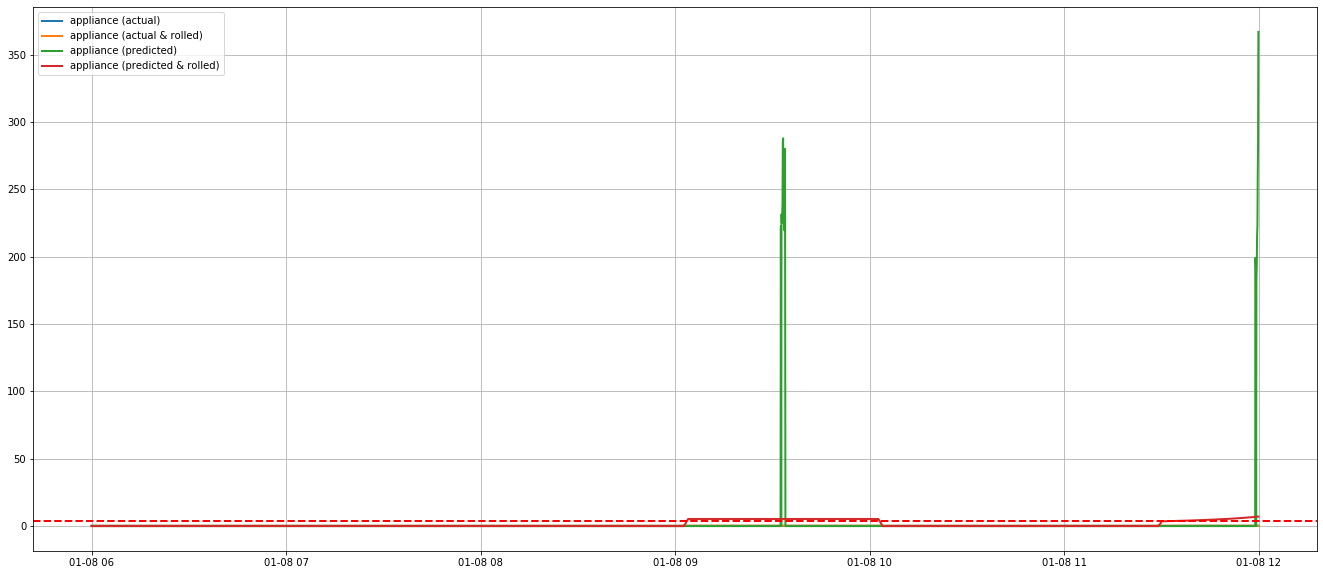

New sensible chunk: 3600
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:    0.7s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:    1.1s
[Parallel(n_jobs=32)]: Done 2300 out of 2300 | elapsed:    1.4s finished


Disaggregation is done..
============ Relative error in total energy: 0.11200694618567891
============ Mean absolute error(in Watts): 51.12049324671321
============ Recall: 0.9915254237288136
============ Precision: 0.07158152340165189
============ Accuracy: 0.15638888888888888
============ F1 Score: 0.1335235378031384
3600
3600
least_amount = 177.5738444444445
upper = 75.54825315506326
2017-01-08 17:00:00+09:00
count1 = 329
count2 = 600
recall = 0.16666666666666666
precision = 1.0
accuracy = 0.16666666666666666
f1 = 0.2857142857142857
# of peaks = 1
activations : [3300]


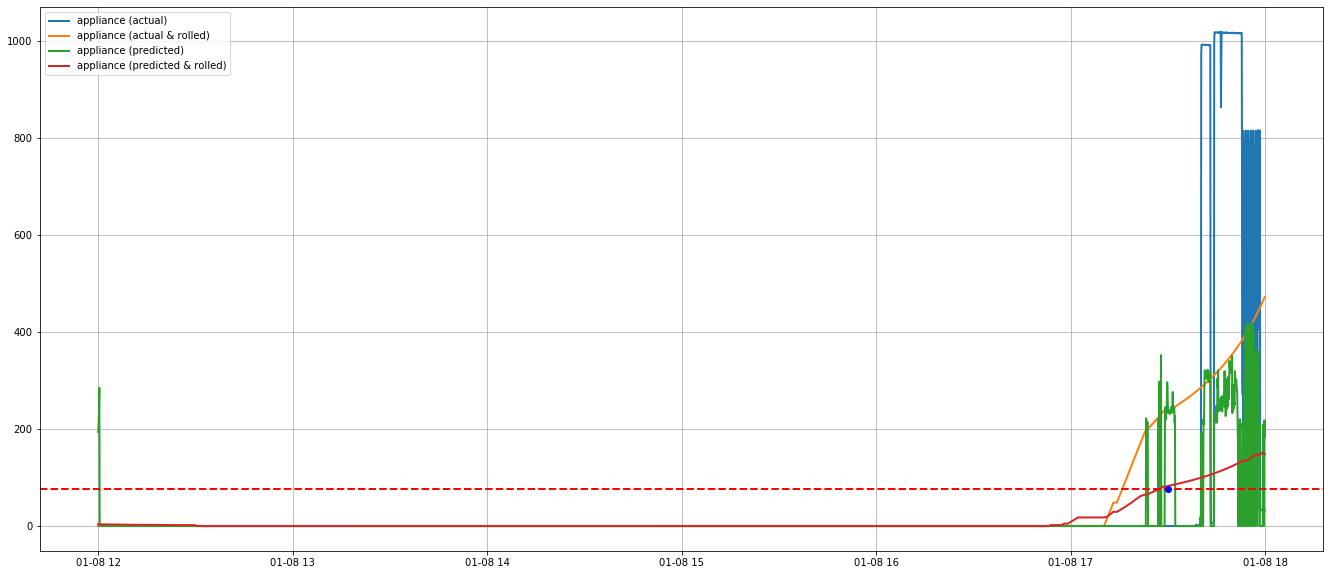

New sensible chunk: 3600
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:    1.1s
[Parallel(n_jobs=32)]: Done 2300 out of 2300 | elapsed:    1.4s finished


Disaggregation is done..
============ Relative error in total energy: 0.9579524237691214
============ Mean absolute error(in Watts): 24.567113521152958
============ Recall: 0.7459016393442623
============ Precision: 0.0396860008722198
============ Accuracy: 0.37972222222222224
============ F1 Score: 0.07536231884057971
3600
3600
least_amount = 177.5738444444445
upper = 16.000801747639972
2017-01-08 18:00:00+09:00
count1 = 300
count2 = 600
recall = 0.16666666666666666
precision = 1.0
accuracy = 0.16666666666666666
f1 = 0.2857142857142857
# of peaks = 1
activations : [300]


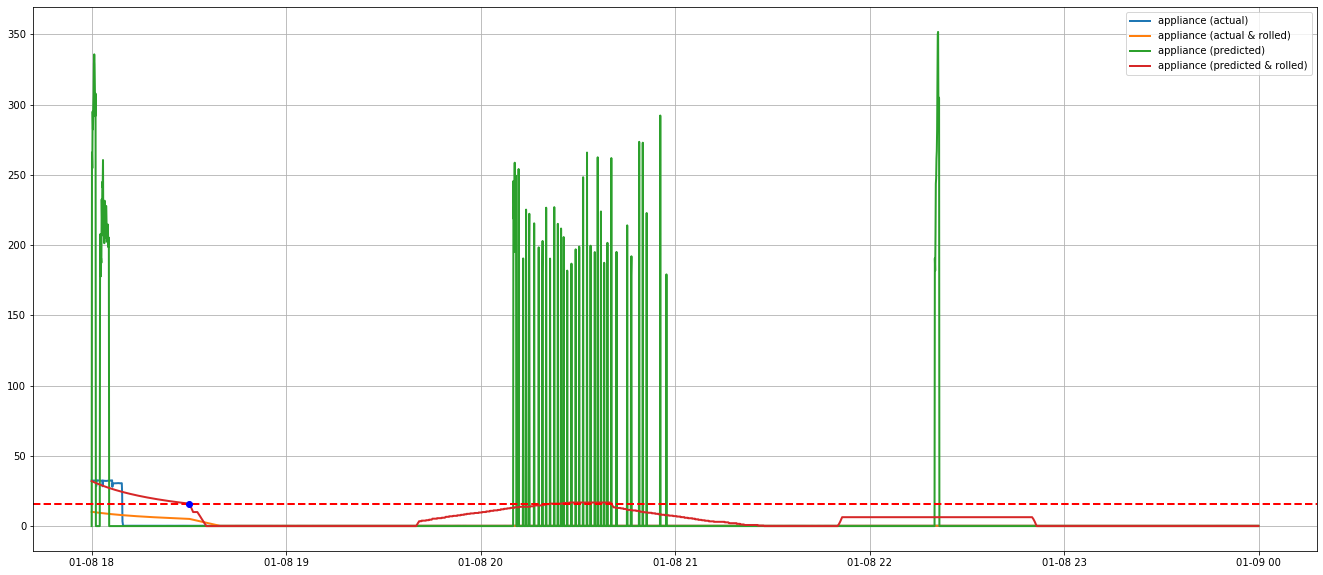

1

In [573]:
disaggregate(dataset, model, 9, 'rice cooker', '2017-01-08 00:00:00', '2017-01-08 06:00:00', True)
disaggregate(dataset, model, 9, 'rice cooker', '2017-01-08 06:00:00', '2017-01-08 12:00:00', True)
disaggregate(dataset, model, 9, 'rice cooker', '2017-01-08 12:00:00', '2017-01-08 18:00:00', True)
disaggregate(dataset, model, 9, 'rice cooker', '2017-01-08 18:00:00', '2017-01-09 00:00:00', True)

New sensible chunk: 3600
feature selection is done..


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:    0.1s
[Parallel(n_jobs=32)]: Done 386 tasks      | elapsed:    0.3s
[Parallel(n_jobs=32)]: Done 736 tasks      | elapsed:    0.5s
[Parallel(n_jobs=32)]: Done 1186 tasks      | elapsed:    0.8s
[Parallel(n_jobs=32)]: Done 1736 tasks      | elapsed:    1.1s
[Parallel(n_jobs=32)]: Done 2300 out of 2300 | elapsed:    1.4s finished


Disaggregation is done..
============ Relative error in total energy: 0.007186979598100877
============ Mean absolute error(in Watts): 63.56329576797236
============ Recall: 0.9656862745098039
============ Precision: 0.3579648697758934
============ Accuracy: 0.6997222222222222
============ F1 Score: 0.5223155103844455
least_amount = 177.5738444444445
upper = 72.31600588480632
2017-01-22 08:00:00+09:00
count1 = 294
count2 = 600
2017-01-22 09:00:00+09:00
count1 = 306
count2 = 600
recall = 0.3333333333333333
precision = 1.0
accuracy = 0.3333333333333333
f1 = 0.5
# of peaks = 2
activations : [1500, 2100]


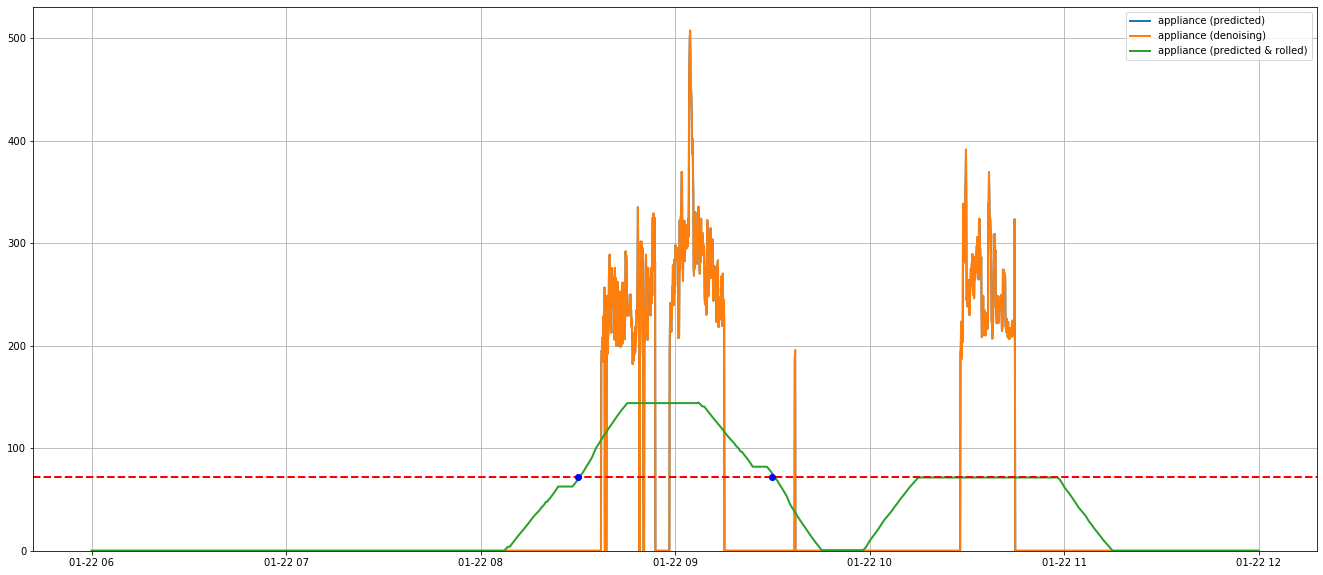

2

In [634]:
disaggregate(dataset, model, 1, 'rice cooker', '2017-01-22 06:00:00', '2017-01-22 12:00:00', True)